In [199]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from einops import rearrange, reduce
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pandas as pd

In [4]:
path = "/media/dan/Data/data/sourcesink_As/001_000500_000500.hdf5"

In [5]:
# load the data
with h5py.File(path,'r') as f:
    # print(f['metadata/patient_info'].keys())
    data = f['data/A_mats'][()] 
    soz = f['metadata/patient_info/soz'][()]

In [6]:
data.shape

(118, 118, 609)

In [7]:
soz

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [8]:
np.where(soz == 1)

(array([ 90,  91,  92,  98,  99, 100, 101]),)

In [9]:
eye = np.eye(data.shape[0])
eye = np.abs(eye - 1)
zdata = data * rearrange(eye, 'i j -> i j 1')

In [10]:
zdata.shape

(118, 118, 609)

In [11]:
def znorm(data):
    flat = rearrange(data, 'i j t -> (i j) t')
    m = np.mean(flat, axis=0)
    s = np.std(flat, axis=0)

    t = (data - m) / s
    eye = np.eye(data.shape[0])
    eye = np.abs(eye - 1)
    t = t * rearrange(eye, 'i j -> i j 1')

    return t
zdata = znorm(zdata)


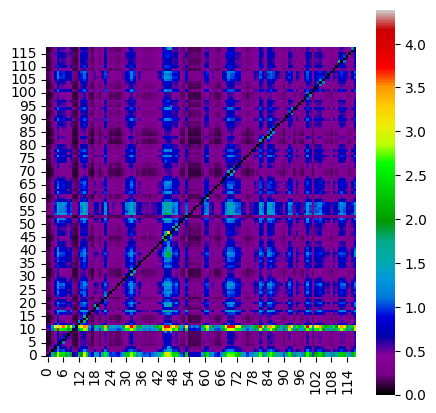

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(np.median(np.abs(zdata), axis=2), cmap='nipy_spectral', cbar=True, square=True,ax=ax)
ax.invert_yaxis()

In [13]:
d = np.arange(100)
d = d.reshape(10,-1)
d

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
       [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
       [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
       [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
       [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
       [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]])

In [14]:
def extract_rows_and_cols(matrix):
    """
    Extract and concatenate rows and columns from an n×n matrix.
    
    Parameters:
    matrix : numpy.ndarray
        An n×n matrix
        
    Returns:
    numpy.ndarray
        Array of shape (n, 2n) where each row contains the concatenated
        row and column vectors for each index
    """
    if not isinstance(matrix, np.ndarray):
        matrix = np.array(matrix)
    
    n = matrix.shape[0]
    if matrix.shape != (n, n):
        raise ValueError("Input must be a square matrix")
    
    # Initialize output array to store concatenated vectors
    result = np.zeros((n, 2*n))
    
    for i in range(n):
        # Get row i and column i
        row_i = matrix[i, :]
        col_i = matrix[:, i]
        
        # Concatenate them and store in result
        result[i] = np.concatenate([row_i, col_i])
    
    return result

In [15]:
inputs = []
for i in range(data.shape[-1]):
    inputs.extend(extract_rows_and_cols(zdata[:,:,i]))
inputs = np.array(inputs)
n = data.shape[-1]
# repeate soz n times to match inputs
labels = np.tile(soz, n).T.reshape(-1,1)


In [16]:
# simple 4 layer network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        four = inputs.shape[1]*4
        self.fc1 = nn.Linear(inputs.shape[1], four)
        self.fc2 = nn.Linear(four, four)
        self.fc3 = nn.Linear(four, four)
        self.fc4 = nn.Linear(four, four//2)
        self.fc5 = nn.Linear(four//2, four//8)
        self.fc6 = nn.Linear(four//8, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        x = torch.sigmoid(self.fc6(x))
        return x
    
# Best model tracking class
class ModelCheckpoint:
    def __init__(self, path='best_model.pth'):
        self.path = path
        self.best_loss = float('inf')
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            return True
        return False
        
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.path)


net = Net()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

if type(inputs) == np.ndarray:
    inputs = torch.from_numpy(inputs).float()
    labels = torch.from_numpy(labels).float()

# check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

# shuffle the data
indices = torch.randperm(inputs.shape[0])
inputs = inputs[indices]
labels = labels[indices]

# Split into train (70%), validation (15%), and test (15%)
train_inputs = inputs[:int(inputs.shape[0]*0.7)]
train_labels = labels[:int(labels.shape[0]*0.7)]

temp_inputs = inputs[int(inputs.shape[0]*0.7):]
temp_labels = labels[int(labels.shape[0]*0.7):]

val_inputs = temp_inputs[:int(temp_inputs.shape[0]*0.5)]
val_labels = temp_labels[:int(temp_labels.shape[0]*0.5)]

test_inputs = temp_inputs[int(temp_inputs.shape[0]*0.5):]
test_labels = temp_labels[int(temp_labels.shape[0]*0.5):]

# move all data to gpu
train_inputs = train_inputs.to(device)
train_labels = train_labels.to(device)
val_inputs = val_inputs.to(device)
val_labels = val_labels.to(device)
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)


  0%|          | 2/100000 [00:00<5:16:05,  5.27it/s]

Epoch 0: New best model saved (val_loss: 0.5674)
Epoch 0:
Training Loss: 0.7164
Validation Loss: 0.5674
Epoch 1: New best model saved (val_loss: 0.3713)


  0%|          | 4/100000 [00:00<4:51:49,  5.71it/s]

Epoch 2: New best model saved (val_loss: 0.3087)


  0%|          | 7/100000 [00:01<4:48:46,  5.77it/s]

Epoch 5: New best model saved (val_loss: 0.2674)
Epoch 6: New best model saved (val_loss: 0.2250)


  0%|          | 9/100000 [00:01<4:51:56,  5.71it/s]

Epoch 7: New best model saved (val_loss: 0.2080)
Epoch 8: New best model saved (val_loss: 0.2075)


  0%|          | 12/100000 [00:02<4:52:30,  5.70it/s]

Epoch 10: New best model saved (val_loss: 0.2059)
Epoch 11: New best model saved (val_loss: 0.2026)


  0%|          | 14/100000 [00:02<4:53:25,  5.68it/s]

Epoch 12: New best model saved (val_loss: 0.2009)
Epoch 13: New best model saved (val_loss: 0.1996)


  0%|          | 16/100000 [00:02<4:55:32,  5.64it/s]

Epoch 14: New best model saved (val_loss: 0.1992)
Epoch 15: New best model saved (val_loss: 0.1972)


  0%|          | 18/100000 [00:03<4:54:41,  5.65it/s]

Epoch 16: New best model saved (val_loss: 0.1945)
Epoch 17: New best model saved (val_loss: 0.1910)


  0%|          | 20/100000 [00:03<4:56:56,  5.61it/s]

Epoch 18: New best model saved (val_loss: 0.1884)
Epoch 19: New best model saved (val_loss: 0.1868)


  0%|          | 22/100000 [00:03<4:57:46,  5.60it/s]

Epoch 20: New best model saved (val_loss: 0.1854)
Epoch 21: New best model saved (val_loss: 0.1851)


  0%|          | 27/100000 [00:04<4:53:26,  5.68it/s]

Epoch 25: New best model saved (val_loss: 0.1848)
Epoch 26: New best model saved (val_loss: 0.1847)


  0%|          | 32/100000 [00:05<4:50:18,  5.74it/s]

Epoch 30: New best model saved (val_loss: 0.1845)
Epoch 31: New best model saved (val_loss: 0.1840)


  0%|          | 34/100000 [00:05<4:47:19,  5.80it/s]

Epoch 32: New best model saved (val_loss: 0.1839)


  0%|          | 37/100000 [00:06<4:44:39,  5.85it/s]

Epoch 35: New best model saved (val_loss: 0.1838)


  0%|          | 47/100000 [00:08<4:43:34,  5.87it/s]

Epoch 45: New best model saved (val_loss: 0.1836)
Epoch 46: New best model saved (val_loss: 0.1834)


  0%|          | 51/100000 [00:08<4:44:33,  5.85it/s]

Epoch 49: New best model saved (val_loss: 0.1831)
Epoch 50: New best model saved (val_loss: 0.1826)


  0%|          | 53/100000 [00:09<4:48:11,  5.78it/s]

Epoch 51: New best model saved (val_loss: 0.1821)
Epoch 52: New best model saved (val_loss: 0.1819)


  0%|          | 55/100000 [00:09<4:49:36,  5.75it/s]

Epoch 53: New best model saved (val_loss: 0.1817)
Epoch 54: New best model saved (val_loss: 0.1815)


  0%|          | 57/100000 [00:09<4:52:29,  5.69it/s]

Epoch 55: New best model saved (val_loss: 0.1811)
Epoch 56: New best model saved (val_loss: 0.1808)


  0%|          | 59/100000 [00:10<4:53:02,  5.68it/s]

Epoch 57: New best model saved (val_loss: 0.1806)
Epoch 58: New best model saved (val_loss: 0.1805)


  0%|          | 61/100000 [00:10<4:52:51,  5.69it/s]

Epoch 59: New best model saved (val_loss: 0.1803)
Epoch 60: New best model saved (val_loss: 0.1802)


  0%|          | 63/100000 [00:10<4:47:36,  5.79it/s]

Epoch 61: New best model saved (val_loss: 0.1800)


  0%|          | 79/100000 [00:13<4:36:17,  6.03it/s]

Epoch 77: New best model saved (val_loss: 0.1788)


  0%|          | 102/100000 [00:17<4:33:56,  6.08it/s]

Epoch 100:
Training Loss: 0.0924
Validation Loss: 0.1946


  0%|          | 202/100000 [00:33<4:32:48,  6.10it/s]

Epoch 200:
Training Loss: 0.0640
Validation Loss: 0.2234


  0%|          | 302/100000 [00:50<4:30:05,  6.15it/s]

Epoch 300:
Training Loss: 0.0014
Validation Loss: 0.8192


  0%|          | 402/100000 [01:06<4:35:36,  6.02it/s]

Epoch 400:
Training Loss: 0.0003
Validation Loss: 1.1605


  1%|          | 502/100000 [01:22<4:35:38,  6.02it/s]

Epoch 500:
Training Loss: 0.0001
Validation Loss: 1.3828


  1%|          | 602/100000 [01:39<4:44:49,  5.82it/s]

Epoch 600:
Training Loss: 0.0001
Validation Loss: 1.5013


  1%|          | 702/100000 [01:56<4:34:15,  6.03it/s]

Epoch 700:
Training Loss: 0.0001
Validation Loss: 1.5799


  1%|          | 802/100000 [02:13<4:38:09,  5.94it/s]

Epoch 800:
Training Loss: 0.0000
Validation Loss: 1.6396


  1%|          | 902/100000 [02:30<4:34:30,  6.02it/s]

Epoch 900:
Training Loss: 0.0000
Validation Loss: 1.6778


  1%|          | 1002/100000 [02:46<4:36:29,  5.97it/s]

Epoch 1000:
Training Loss: 0.0000
Validation Loss: 1.7567


  1%|          | 1102/100000 [03:03<4:38:24,  5.92it/s]

Epoch 1100:
Training Loss: 0.0000
Validation Loss: 1.8243


  1%|          | 1202/100000 [03:20<4:39:08,  5.90it/s]

Epoch 1200:
Training Loss: 0.0000
Validation Loss: 1.8735


  1%|▏         | 1302/100000 [03:37<4:36:32,  5.95it/s]

Epoch 1300:
Training Loss: 0.0000
Validation Loss: 1.9137


  1%|▏         | 1402/100000 [03:54<4:36:09,  5.95it/s]

Epoch 1400:
Training Loss: 0.0000
Validation Loss: 1.9510


  2%|▏         | 1502/100000 [04:11<4:39:49,  5.87it/s]

Epoch 1500:
Training Loss: 0.0000
Validation Loss: 1.9789


  2%|▏         | 1602/100000 [04:28<4:38:21,  5.89it/s]

Epoch 1600:
Training Loss: 0.0000
Validation Loss: 2.0064


  2%|▏         | 1702/100000 [04:45<4:44:11,  5.76it/s]

Epoch 1700:
Training Loss: 0.0000
Validation Loss: 2.0318


  2%|▏         | 1802/100000 [05:02<4:41:07,  5.82it/s]

Epoch 1800:
Training Loss: 0.0000
Validation Loss: 2.0572


  2%|▏         | 1902/100000 [05:19<4:31:48,  6.02it/s]

Epoch 1900:
Training Loss: 0.0000
Validation Loss: 2.1040


  2%|▏         | 2002/100000 [05:36<4:32:35,  5.99it/s]

Epoch 2000:
Training Loss: 0.0000
Validation Loss: 2.1266


  2%|▏         | 2102/100000 [05:53<4:36:48,  5.89it/s]

Epoch 2100:
Training Loss: 0.0000
Validation Loss: 2.1564


  2%|▏         | 2202/100000 [06:10<4:31:39,  6.00it/s]

Epoch 2200:
Training Loss: 0.0000
Validation Loss: 2.1875


  2%|▏         | 2302/100000 [06:27<4:44:00,  5.73it/s]

Epoch 2300:
Training Loss: 0.0000
Validation Loss: 2.2104


  2%|▏         | 2402/100000 [06:43<4:33:44,  5.94it/s]

Epoch 2400:
Training Loss: 0.0000
Validation Loss: 2.2304


  3%|▎         | 2502/100000 [07:00<4:28:26,  6.05it/s]

Epoch 2500:
Training Loss: 0.0000
Validation Loss: 2.2501


  3%|▎         | 2602/100000 [07:17<4:31:27,  5.98it/s]

Epoch 2600:
Training Loss: 0.0000
Validation Loss: 2.2693


  3%|▎         | 2702/100000 [07:33<4:26:42,  6.08it/s]

Epoch 2700:
Training Loss: 0.0000
Validation Loss: 2.2825


  3%|▎         | 2802/100000 [07:50<4:35:00,  5.89it/s]

Epoch 2800:
Training Loss: 0.0000
Validation Loss: 2.3177


  3%|▎         | 2902/100000 [08:07<4:32:13,  5.94it/s]

Epoch 2900:
Training Loss: 0.0000
Validation Loss: 2.3369


  3%|▎         | 3002/100000 [08:24<4:28:39,  6.02it/s]

Epoch 3000:
Training Loss: 0.0000
Validation Loss: 2.3469


  3%|▎         | 3102/100000 [08:40<4:27:52,  6.03it/s]

Epoch 3100:
Training Loss: 0.0000
Validation Loss: 2.3723


  3%|▎         | 3202/100000 [08:57<4:30:53,  5.96it/s]

Epoch 3200:
Training Loss: 0.0000
Validation Loss: 2.3898


  3%|▎         | 3302/100000 [09:14<4:33:52,  5.88it/s]

Epoch 3300:
Training Loss: 0.0000
Validation Loss: 2.3992


  3%|▎         | 3402/100000 [09:30<4:26:36,  6.04it/s]

Epoch 3400:
Training Loss: 0.0000
Validation Loss: 2.4084


  4%|▎         | 3502/100000 [09:47<4:35:48,  5.83it/s]

Epoch 3500:
Training Loss: 0.0000
Validation Loss: 2.4252


  4%|▎         | 3602/100000 [10:04<4:31:09,  5.93it/s]

Epoch 3600:
Training Loss: 0.0000
Validation Loss: 2.4341


  4%|▎         | 3702/100000 [10:21<4:34:29,  5.85it/s]

Epoch 3700:
Training Loss: 0.0000
Validation Loss: 2.4585


  4%|▍         | 3802/100000 [10:38<4:32:10,  5.89it/s]

Epoch 3800:
Training Loss: 0.0000
Validation Loss: 2.4671


  4%|▍         | 3902/100000 [10:55<4:35:14,  5.82it/s]

Epoch 3900:
Training Loss: 0.0000
Validation Loss: 2.4756


  4%|▍         | 4002/100000 [11:12<4:25:33,  6.02it/s]

Epoch 4000:
Training Loss: 0.0000
Validation Loss: 2.4840


  4%|▍         | 4102/100000 [11:29<4:29:43,  5.93it/s]

Epoch 4100:
Training Loss: 0.0000
Validation Loss: 2.4924


  4%|▍         | 4202/100000 [11:46<4:36:31,  5.77it/s]

Epoch 4200:
Training Loss: 0.0000
Validation Loss: 2.5016


  4%|▍         | 4302/100000 [12:03<4:24:21,  6.03it/s]

Epoch 4300:
Training Loss: 0.0000
Validation Loss: 2.5096


  4%|▍         | 4402/100000 [12:19<4:30:28,  5.89it/s]

Epoch 4400:
Training Loss: 0.0000
Validation Loss: 2.5185


  5%|▍         | 4502/100000 [12:36<4:24:46,  6.01it/s]

Epoch 4500:
Training Loss: 0.0000
Validation Loss: 2.5274


  5%|▍         | 4602/100000 [12:53<4:20:59,  6.09it/s]

Epoch 4600:
Training Loss: 0.0000
Validation Loss: 2.5351


  5%|▍         | 4702/100000 [13:09<4:23:16,  6.03it/s]

Epoch 4700:
Training Loss: 0.0000
Validation Loss: 2.5438


  5%|▍         | 4802/100000 [13:26<4:25:38,  5.97it/s]

Epoch 4800:
Training Loss: 0.0000
Validation Loss: 2.5591


  5%|▍         | 4902/100000 [13:43<4:21:47,  6.05it/s]

Epoch 4900:
Training Loss: 0.0000
Validation Loss: 2.5664


  5%|▌         | 5002/100000 [13:59<4:26:19,  5.95it/s]

Epoch 5000:
Training Loss: 0.0000
Validation Loss: 2.5739


  5%|▌         | 5102/100000 [14:16<4:21:23,  6.05it/s]

Epoch 5100:
Training Loss: 0.0000
Validation Loss: 2.5900


  5%|▌         | 5202/100000 [14:33<4:27:54,  5.90it/s]

Epoch 5200:
Training Loss: 0.0000
Validation Loss: 2.6050


  5%|▌         | 5302/100000 [14:50<4:29:48,  5.85it/s]

Epoch 5300:
Training Loss: 0.0000
Validation Loss: 2.6121


  5%|▌         | 5402/100000 [15:06<4:23:53,  5.97it/s]

Epoch 5400:
Training Loss: 0.0000
Validation Loss: 2.6191


  6%|▌         | 5502/100000 [15:23<4:23:00,  5.99it/s]

Epoch 5500:
Training Loss: 0.0000
Validation Loss: 2.6339


  6%|▌         | 5602/100000 [15:39<4:21:24,  6.02it/s]

Epoch 5600:
Training Loss: 0.0000
Validation Loss: 2.6418


  6%|▌         | 5702/100000 [15:56<4:22:44,  5.98it/s]

Epoch 5700:
Training Loss: 0.0000
Validation Loss: 2.6487


  6%|▌         | 5802/100000 [16:13<4:24:27,  5.94it/s]

Epoch 5800:
Training Loss: 0.0000
Validation Loss: 2.6556


  6%|▌         | 5902/100000 [16:30<4:19:53,  6.03it/s]

Epoch 5900:
Training Loss: 0.0000
Validation Loss: 2.6634


  6%|▌         | 6002/100000 [16:46<4:25:16,  5.91it/s]

Epoch 6000:
Training Loss: 0.0000
Validation Loss: 2.6869


  6%|▌         | 6102/100000 [17:03<4:27:09,  5.86it/s]

Epoch 6100:
Training Loss: 0.0000
Validation Loss: 2.7014


  6%|▌         | 6202/100000 [17:20<4:29:22,  5.80it/s]

Epoch 6200:
Training Loss: 0.0000
Validation Loss: 2.7101


  6%|▋         | 6302/100000 [17:38<4:25:09,  5.89it/s]

Epoch 6300:
Training Loss: 0.0000
Validation Loss: 2.7166


  6%|▋         | 6402/100000 [17:55<4:23:12,  5.93it/s]

Epoch 6400:
Training Loss: 0.0000
Validation Loss: 2.7240


  7%|▋         | 6502/100000 [18:11<4:22:22,  5.94it/s]

Epoch 6500:
Training Loss: 0.0000
Validation Loss: 2.7382


  7%|▋         | 6602/100000 [18:28<4:23:02,  5.92it/s]

Epoch 6600:
Training Loss: 0.0000
Validation Loss: 2.7534


  7%|▋         | 6702/100000 [18:45<4:17:48,  6.03it/s]

Epoch 6700:
Training Loss: 0.0000
Validation Loss: 2.7608


  7%|▋         | 6802/100000 [19:02<4:23:44,  5.89it/s]

Epoch 6800:
Training Loss: 0.0000
Validation Loss: 2.7759


  7%|▋         | 6902/100000 [19:18<4:15:37,  6.07it/s]

Epoch 6900:
Training Loss: 0.0000
Validation Loss: 2.7822


  7%|▋         | 7002/100000 [19:35<4:13:25,  6.12it/s]

Epoch 7000:
Training Loss: 0.0000
Validation Loss: 2.7972


  7%|▋         | 7102/100000 [19:52<4:17:24,  6.01it/s]

Epoch 7100:
Training Loss: 0.0000
Validation Loss: 2.8034


  7%|▋         | 7202/100000 [20:08<4:24:27,  5.85it/s]

Epoch 7200:
Training Loss: 0.0000
Validation Loss: 2.8172


  7%|▋         | 7302/100000 [20:25<4:16:04,  6.03it/s]

Epoch 7300:
Training Loss: 0.0000
Validation Loss: 2.8234


  7%|▋         | 7402/100000 [20:42<4:22:40,  5.88it/s]

Epoch 7400:
Training Loss: 0.0000
Validation Loss: 2.8305


  8%|▊         | 7502/100000 [20:59<4:16:10,  6.02it/s]

Epoch 7500:
Training Loss: 0.0000
Validation Loss: 2.8375


  8%|▊         | 7602/100000 [21:15<4:12:44,  6.09it/s]

Epoch 7600:
Training Loss: 0.0000
Validation Loss: 2.8513


  8%|▊         | 7702/100000 [21:32<4:14:42,  6.04it/s]

Epoch 7700:
Training Loss: 0.0000
Validation Loss: 2.8727


  8%|▊         | 7802/100000 [21:49<4:22:40,  5.85it/s]

Epoch 7800:
Training Loss: 0.0000
Validation Loss: 2.8865


  8%|▊         | 7902/100000 [22:05<4:17:12,  5.97it/s]

Epoch 7900:
Training Loss: 0.0000
Validation Loss: 2.8923


  8%|▊         | 8002/100000 [22:22<4:13:24,  6.05it/s]

Epoch 8000:
Training Loss: 0.0000
Validation Loss: 2.9060


  8%|▊         | 8102/100000 [22:39<4:19:31,  5.90it/s]

Epoch 8100:
Training Loss: 0.0000
Validation Loss: 2.9139


  8%|▊         | 8202/100000 [22:56<4:17:33,  5.94it/s]

Epoch 8200:
Training Loss: 0.0000
Validation Loss: 2.9207


  8%|▊         | 8302/100000 [23:13<4:15:21,  5.98it/s]

Epoch 8300:
Training Loss: 0.0000
Validation Loss: 2.9352


  8%|▊         | 8402/100000 [23:29<4:14:40,  5.99it/s]

Epoch 8400:
Training Loss: 0.0000
Validation Loss: 2.9421


  9%|▊         | 8502/100000 [23:46<4:17:23,  5.92it/s]

Epoch 8500:
Training Loss: 0.0000
Validation Loss: 2.9487


  9%|▊         | 8602/100000 [24:03<4:17:06,  5.92it/s]

Epoch 8600:
Training Loss: 0.0000
Validation Loss: 2.9543


  9%|▊         | 8702/100000 [24:20<4:16:37,  5.93it/s]

Epoch 8700:
Training Loss: 0.0000
Validation Loss: 2.9609


  9%|▉         | 8802/100000 [24:36<4:16:59,  5.91it/s]

Epoch 8800:
Training Loss: 0.0000
Validation Loss: 2.9909


  9%|▉         | 8902/100000 [24:53<4:14:46,  5.96it/s]

Epoch 8900:
Training Loss: 0.0000
Validation Loss: 3.0042


  9%|▉         | 9002/100000 [25:10<4:17:34,  5.89it/s]

Epoch 9000:
Training Loss: 0.0000
Validation Loss: 3.0096


  9%|▉         | 9102/100000 [25:26<4:11:08,  6.03it/s]

Epoch 9100:
Training Loss: 0.0000
Validation Loss: 3.0229


  9%|▉         | 9202/100000 [25:43<4:11:42,  6.01it/s]

Epoch 9200:
Training Loss: 0.0000
Validation Loss: 3.0284


  9%|▉         | 9302/100000 [26:00<4:07:13,  6.11it/s]

Epoch 9300:
Training Loss: 0.0000
Validation Loss: 3.0494


  9%|▉         | 9402/100000 [26:16<4:07:52,  6.09it/s]

Epoch 9400:
Training Loss: 0.0000
Validation Loss: 3.0626


 10%|▉         | 9502/100000 [26:33<4:09:23,  6.05it/s]

Epoch 9500:
Training Loss: 0.0000
Validation Loss: 3.0758


 10%|▉         | 9602/100000 [26:50<4:10:29,  6.01it/s]

Epoch 9600:
Training Loss: 0.0000
Validation Loss: 3.0811


 10%|▉         | 9702/100000 [27:06<4:13:30,  5.94it/s]

Epoch 9700:
Training Loss: 0.0000
Validation Loss: 3.0863


 10%|▉         | 9802/100000 [27:23<4:07:10,  6.08it/s]

Epoch 9800:
Training Loss: 0.0000
Validation Loss: 3.0916


 10%|▉         | 9902/100000 [27:40<4:12:43,  5.94it/s]

Epoch 9900:
Training Loss: 0.0000
Validation Loss: 3.0969


 10%|█         | 10002/100000 [27:56<4:07:16,  6.07it/s]

Epoch 10000:
Training Loss: 0.0000
Validation Loss: 3.1026


 10%|█         | 10102/100000 [28:13<4:04:37,  6.13it/s]

Epoch 10100:
Training Loss: 0.0000
Validation Loss: 3.1157


 10%|█         | 10202/100000 [28:30<4:18:31,  5.79it/s]

Epoch 10200:
Training Loss: 0.0000
Validation Loss: 3.1289


 10%|█         | 10302/100000 [28:46<4:08:54,  6.01it/s]

Epoch 10300:
Training Loss: 0.0000
Validation Loss: 3.1421


 10%|█         | 10402/100000 [29:03<4:06:50,  6.05it/s]

Epoch 10400:
Training Loss: 0.0000
Validation Loss: 3.1563


 11%|█         | 10502/100000 [29:20<4:08:11,  6.01it/s]

Epoch 10500:
Training Loss: 0.0000
Validation Loss: 3.1635


 11%|█         | 10602/100000 [29:36<4:08:55,  5.99it/s]

Epoch 10600:
Training Loss: 0.0000
Validation Loss: 3.1685


 11%|█         | 10702/100000 [29:53<4:04:19,  6.09it/s]

Epoch 10700:
Training Loss: 0.0000
Validation Loss: 3.1747


 11%|█         | 10802/100000 [30:09<4:08:18,  5.99it/s]

Epoch 10800:
Training Loss: 0.0000
Validation Loss: 3.1799


 11%|█         | 10902/100000 [30:26<4:05:54,  6.04it/s]

Epoch 10900:
Training Loss: 0.0000
Validation Loss: 3.2018


 11%|█         | 11002/100000 [30:43<4:10:03,  5.93it/s]

Epoch 11000:
Training Loss: 0.0000
Validation Loss: 3.2090


 11%|█         | 11102/100000 [30:59<4:07:45,  5.98it/s]

Epoch 11100:
Training Loss: 0.0000
Validation Loss: 3.2140


 11%|█         | 11202/100000 [31:16<4:09:13,  5.94it/s]

Epoch 11200:
Training Loss: 0.0000
Validation Loss: 3.2267


 11%|█▏        | 11302/100000 [31:33<4:07:56,  5.96it/s]

Epoch 11300:
Training Loss: 0.0000
Validation Loss: 3.2327


 11%|█▏        | 11402/100000 [31:50<4:12:05,  5.86it/s]

Epoch 11400:
Training Loss: 0.0000
Validation Loss: 3.2398


 12%|█▏        | 11502/100000 [32:07<4:07:10,  5.97it/s]

Epoch 11500:
Training Loss: 0.0000
Validation Loss: 3.2457


 12%|█▏        | 11602/100000 [32:23<4:02:38,  6.07it/s]

Epoch 11600:
Training Loss: 0.0000
Validation Loss: 3.2506


 12%|█▏        | 11702/100000 [32:40<4:03:12,  6.05it/s]

Epoch 11700:
Training Loss: 0.0000
Validation Loss: 3.2555


 12%|█▏        | 11802/100000 [32:56<4:01:04,  6.10it/s]

Epoch 11800:
Training Loss: 0.0000
Validation Loss: 3.2604


 12%|█▏        | 11902/100000 [33:13<4:01:24,  6.08it/s]

Epoch 11900:
Training Loss: 0.0000
Validation Loss: 3.2654


 12%|█▏        | 12002/100000 [33:29<4:04:24,  6.00it/s]

Epoch 12000:
Training Loss: 0.0000
Validation Loss: 3.2702


 12%|█▏        | 12102/100000 [33:46<4:02:09,  6.05it/s]

Epoch 12100:
Training Loss: 0.0000
Validation Loss: 3.2750


 12%|█▏        | 12202/100000 [34:02<3:59:27,  6.11it/s]

Epoch 12200:
Training Loss: 0.0000
Validation Loss: 3.2809


 12%|█▏        | 12302/100000 [34:19<4:00:40,  6.07it/s]

Epoch 12300:
Training Loss: 0.0000
Validation Loss: 3.2857


 12%|█▏        | 12402/100000 [34:35<3:58:48,  6.11it/s]

Epoch 12400:
Training Loss: 0.0000
Validation Loss: 3.2915


 13%|█▎        | 12502/100000 [34:52<4:07:40,  5.89it/s]

Epoch 12500:
Training Loss: 0.0000
Validation Loss: 3.3119


 13%|█▎        | 12602/100000 [35:08<4:00:21,  6.06it/s]

Epoch 12600:
Training Loss: 0.0000
Validation Loss: 3.3246


 13%|█▎        | 12702/100000 [35:25<4:03:48,  5.97it/s]

Epoch 12700:
Training Loss: 0.0000
Validation Loss: 3.3295


 13%|█▎        | 12802/100000 [35:42<3:59:18,  6.07it/s]

Epoch 12800:
Training Loss: 0.0000
Validation Loss: 3.3343


 13%|█▎        | 12902/100000 [35:59<4:04:24,  5.94it/s]

Epoch 12900:
Training Loss: 0.0000
Validation Loss: 3.3421


 13%|█▎        | 13002/100000 [36:15<3:57:43,  6.10it/s]

Epoch 13000:
Training Loss: 0.0000
Validation Loss: 3.3477


 13%|█▎        | 13102/100000 [36:32<4:00:08,  6.03it/s]

Epoch 13100:
Training Loss: 0.0000
Validation Loss: 3.3522


 13%|█▎        | 13202/100000 [36:48<3:57:57,  6.08it/s]

Epoch 13200:
Training Loss: 0.0000
Validation Loss: 3.3567


 13%|█▎        | 13302/100000 [37:05<4:06:54,  5.85it/s]

Epoch 13300:
Training Loss: 0.0000
Validation Loss: 3.3633


 13%|█▎        | 13402/100000 [37:22<4:01:25,  5.98it/s]

Epoch 13400:
Training Loss: 0.0000
Validation Loss: 3.3688


 14%|█▎        | 13502/100000 [37:38<3:59:59,  6.01it/s]

Epoch 13500:
Training Loss: 0.0000
Validation Loss: 3.3655


 14%|█▎        | 13602/100000 [37:55<4:05:16,  5.87it/s]

Epoch 13600:
Training Loss: 0.0000
Validation Loss: 3.3776


 14%|█▎        | 13702/100000 [38:12<4:02:47,  5.92it/s]

Epoch 13700:
Training Loss: 0.0000
Validation Loss: 3.3896


 14%|█▍        | 13802/100000 [38:29<4:01:13,  5.96it/s]

Epoch 13800:
Training Loss: 0.0000
Validation Loss: 3.3861


 14%|█▍        | 13902/100000 [38:45<4:02:24,  5.92it/s]

Epoch 13900:
Training Loss: 0.0000
Validation Loss: 3.3914


 14%|█▍        | 14002/100000 [39:02<3:54:30,  6.11it/s]

Epoch 14000:
Training Loss: 0.0000
Validation Loss: 3.4046


 14%|█▍        | 14102/100000 [39:19<3:53:45,  6.12it/s]

Epoch 14100:
Training Loss: 0.0000
Validation Loss: 3.4087


 14%|█▍        | 14202/100000 [39:35<3:54:56,  6.09it/s]

Epoch 14200:
Training Loss: 0.0000
Validation Loss: 3.4128


 14%|█▍        | 14302/100000 [39:52<4:01:15,  5.92it/s]

Epoch 14300:
Training Loss: 0.0000
Validation Loss: 3.4168


 14%|█▍        | 14402/100000 [40:09<3:58:39,  5.98it/s]

Epoch 14400:
Training Loss: 0.0000
Validation Loss: 3.4217


 15%|█▍        | 14502/100000 [40:25<3:55:42,  6.05it/s]

Epoch 14500:
Training Loss: 0.0000
Validation Loss: 3.4256


 15%|█▍        | 14602/100000 [40:42<3:53:43,  6.09it/s]

Epoch 14600:
Training Loss: 0.0000
Validation Loss: 3.4214


 15%|█▍        | 14702/100000 [40:58<3:53:00,  6.10it/s]

Epoch 14700:
Training Loss: 0.0000
Validation Loss: 3.4251


 15%|█▍        | 14802/100000 [41:14<3:52:34,  6.11it/s]

Epoch 14800:
Training Loss: 0.0000
Validation Loss: 3.4285


 15%|█▍        | 14902/100000 [41:31<4:02:30,  5.85it/s]

Epoch 14900:
Training Loss: 0.0000
Validation Loss: 3.4330


 15%|█▌        | 15002/100000 [41:48<3:52:29,  6.09it/s]

Epoch 15000:
Training Loss: 0.0000
Validation Loss: 3.4364


 15%|█▌        | 15102/100000 [42:04<3:51:42,  6.11it/s]

Epoch 15100:
Training Loss: 0.0000
Validation Loss: 3.4396


 15%|█▌        | 15202/100000 [42:21<3:52:20,  6.08it/s]

Epoch 15200:
Training Loss: 0.0000
Validation Loss: 3.4439


 15%|█▌        | 15302/100000 [42:37<3:52:43,  6.07it/s]

Epoch 15300:
Training Loss: 0.0000
Validation Loss: 3.4491


 15%|█▌        | 15402/100000 [42:54<3:51:46,  6.08it/s]

Epoch 15400:
Training Loss: 0.0000
Validation Loss: 3.4521


 16%|█▌        | 15502/100000 [43:10<3:52:55,  6.05it/s]

Epoch 15500:
Training Loss: 0.0000
Validation Loss: 3.4551


 16%|█▌        | 15602/100000 [43:27<3:50:02,  6.11it/s]

Epoch 15600:
Training Loss: 0.0000
Validation Loss: 3.4592


 16%|█▌        | 15702/100000 [43:43<3:53:18,  6.02it/s]

Epoch 15700:
Training Loss: 0.0000
Validation Loss: 3.4631


 16%|█▌        | 15802/100000 [44:00<3:51:17,  6.07it/s]

Epoch 15800:
Training Loss: 0.0000
Validation Loss: 3.4660


 16%|█▌        | 15902/100000 [44:16<3:50:57,  6.07it/s]

Epoch 15900:
Training Loss: 0.0000
Validation Loss: 3.4688


 16%|█▌        | 16002/100000 [44:33<3:55:14,  5.95it/s]

Epoch 16000:
Training Loss: 0.0000
Validation Loss: 3.4727


 16%|█▌        | 16102/100000 [44:50<3:53:07,  6.00it/s]

Epoch 16100:
Training Loss: 0.0000
Validation Loss: 3.4753


 16%|█▌        | 16202/100000 [45:07<3:52:18,  6.01it/s]

Epoch 16200:
Training Loss: 0.0000
Validation Loss: 3.4782


 16%|█▋        | 16302/100000 [45:23<3:56:15,  5.90it/s]

Epoch 16300:
Training Loss: 0.0000
Validation Loss: 3.4818


 16%|█▋        | 16402/100000 [45:40<3:52:25,  5.99it/s]

Epoch 16400:
Training Loss: 0.0000
Validation Loss: 3.4844


 17%|█▋        | 16502/100000 [45:57<3:47:39,  6.11it/s]

Epoch 16500:
Training Loss: 0.0000
Validation Loss: 3.4881


 17%|█▋        | 16602/100000 [46:13<3:52:16,  5.98it/s]

Epoch 16600:
Training Loss: 0.0000
Validation Loss: 3.4927


 17%|█▋        | 16702/100000 [46:30<3:51:20,  6.00it/s]

Epoch 16700:
Training Loss: 0.0000
Validation Loss: 3.4885


 17%|█▋        | 16802/100000 [46:46<3:47:50,  6.09it/s]

Epoch 16800:
Training Loss: 0.0000
Validation Loss: 3.4987


 17%|█▋        | 16902/100000 [47:03<3:47:02,  6.10it/s]

Epoch 16900:
Training Loss: 0.0000
Validation Loss: 3.5022


 17%|█▋        | 17002/100000 [47:19<3:50:12,  6.01it/s]

Epoch 17000:
Training Loss: 0.0000
Validation Loss: 3.4968


 17%|█▋        | 17102/100000 [47:36<3:46:51,  6.09it/s]

Epoch 17100:
Training Loss: 0.0000
Validation Loss: 3.4992


 17%|█▋        | 17202/100000 [47:52<3:48:30,  6.04it/s]

Epoch 17200:
Training Loss: 0.0000
Validation Loss: 3.5016


 17%|█▋        | 17302/100000 [48:09<3:45:40,  6.11it/s]

Epoch 17300:
Training Loss: 0.0000
Validation Loss: 3.5060


 17%|█▋        | 17402/100000 [48:25<3:44:56,  6.12it/s]

Epoch 17400:
Training Loss: 0.0000
Validation Loss: 3.5083


 18%|█▊        | 17502/100000 [48:42<3:46:34,  6.07it/s]

Epoch 17500:
Training Loss: 0.0000
Validation Loss: 3.5116


 18%|█▊        | 17602/100000 [48:58<3:44:36,  6.11it/s]

Epoch 17600:
Training Loss: 0.0000
Validation Loss: 3.5138


 18%|█▊        | 17702/100000 [49:15<3:49:35,  5.97it/s]

Epoch 17700:
Training Loss: 0.0000
Validation Loss: 3.5160


 18%|█▊        | 17802/100000 [49:32<3:49:41,  5.96it/s]

Epoch 17800:
Training Loss: 0.0000
Validation Loss: 3.5182


 18%|█▊        | 17902/100000 [49:48<3:43:31,  6.12it/s]

Epoch 17900:
Training Loss: 0.0000
Validation Loss: 3.5205


 18%|█▊        | 18002/100000 [50:05<3:49:11,  5.96it/s]

Epoch 18000:
Training Loss: 0.0000
Validation Loss: 3.5225


 18%|█▊        | 18102/100000 [50:22<3:46:43,  6.02it/s]

Epoch 18100:
Training Loss: 0.0000
Validation Loss: 3.5249


 18%|█▊        | 18202/100000 [50:38<3:44:00,  6.09it/s]

Epoch 18200:
Training Loss: 0.0000
Validation Loss: 3.5279


 18%|█▊        | 18302/100000 [50:55<3:46:05,  6.02it/s]

Epoch 18300:
Training Loss: 0.0000
Validation Loss: 3.5301


 18%|█▊        | 18402/100000 [51:11<3:46:03,  6.02it/s]

Epoch 18400:
Training Loss: 0.0000
Validation Loss: 3.5322


 19%|█▊        | 18502/100000 [51:28<3:49:02,  5.93it/s]

Epoch 18500:
Training Loss: 0.0000
Validation Loss: 3.5341


 19%|█▊        | 18602/100000 [51:44<3:48:42,  5.93it/s]

Epoch 18600:
Training Loss: 0.0000
Validation Loss: 3.5363


 19%|█▊        | 18702/100000 [52:01<3:44:16,  6.04it/s]

Epoch 18700:
Training Loss: 0.0000
Validation Loss: 3.5385


 19%|█▉        | 18802/100000 [52:18<3:46:37,  5.97it/s]

Epoch 18800:
Training Loss: 0.0000
Validation Loss: 3.5484


 19%|█▉        | 18902/100000 [52:35<3:45:09,  6.00it/s]

Epoch 18900:
Training Loss: 0.0000
Validation Loss: 3.5437


 19%|█▉        | 19002/100000 [52:51<3:41:48,  6.09it/s]

Epoch 19000:
Training Loss: 0.0000
Validation Loss: 3.5457


 19%|█▉        | 19102/100000 [53:08<3:41:45,  6.08it/s]

Epoch 19100:
Training Loss: 0.0000
Validation Loss: 3.5565


 19%|█▉        | 19202/100000 [53:24<3:42:29,  6.05it/s]

Epoch 19200:
Training Loss: 0.0000
Validation Loss: 3.5586


 19%|█▉        | 19302/100000 [53:41<3:41:08,  6.08it/s]

Epoch 19300:
Training Loss: 0.0000
Validation Loss: 3.5528


 19%|█▉        | 19402/100000 [53:58<3:42:15,  6.04it/s]

Epoch 19400:
Training Loss: 0.0000
Validation Loss: 3.5547


 20%|█▉        | 19502/100000 [54:14<3:43:27,  6.00it/s]

Epoch 19500:
Training Loss: 0.0000
Validation Loss: 3.5656


 20%|█▉        | 19602/100000 [54:30<3:40:21,  6.08it/s]

Epoch 19600:
Training Loss: 0.0000
Validation Loss: 3.5676


 20%|█▉        | 19702/100000 [54:47<3:39:38,  6.09it/s]

Epoch 19700:
Training Loss: 0.0000
Validation Loss: 3.5614


 20%|█▉        | 19802/100000 [55:04<3:42:12,  6.02it/s]

Epoch 19800:
Training Loss: 0.0000
Validation Loss: 3.5714


 20%|█▉        | 19902/100000 [55:20<3:41:26,  6.03it/s]

Epoch 19900:
Training Loss: 0.0000
Validation Loss: 3.5678


 20%|██        | 20002/100000 [55:37<3:37:51,  6.12it/s]

Epoch 20000:
Training Loss: 0.0000
Validation Loss: 3.5773


 20%|██        | 20102/100000 [55:53<3:42:12,  5.99it/s]

Epoch 20100:
Training Loss: 0.0000
Validation Loss: 3.5794


 20%|██        | 20202/100000 [56:10<3:43:27,  5.95it/s]

Epoch 20200:
Training Loss: 0.0000
Validation Loss: 3.5733


 20%|██        | 20302/100000 [56:27<3:41:55,  5.99it/s]

Epoch 20300:
Training Loss: 0.0000
Validation Loss: 3.5752


 20%|██        | 20402/100000 [56:43<3:37:24,  6.10it/s]

Epoch 20400:
Training Loss: 0.0000
Validation Loss: 3.5771


 21%|██        | 20502/100000 [57:00<3:39:50,  6.03it/s]

Epoch 20500:
Training Loss: 0.0000
Validation Loss: 3.5868


 21%|██        | 20602/100000 [57:16<3:42:44,  5.94it/s]

Epoch 20600:
Training Loss: 0.0000
Validation Loss: 3.5811


 21%|██        | 20702/100000 [57:33<3:38:23,  6.05it/s]

Epoch 20700:
Training Loss: 0.0000
Validation Loss: 3.5829


 21%|██        | 20802/100000 [57:50<3:40:57,  5.97it/s]

Epoch 20800:
Training Loss: 0.0000
Validation Loss: 3.5925


 21%|██        | 20902/100000 [58:06<3:38:13,  6.04it/s]

Epoch 20900:
Training Loss: 0.0000
Validation Loss: 3.5865


 21%|██        | 21002/100000 [58:23<3:40:08,  5.98it/s]

Epoch 21000:
Training Loss: 0.0000
Validation Loss: 3.5962


 21%|██        | 21102/100000 [58:39<3:38:30,  6.02it/s]

Epoch 21100:
Training Loss: 0.0000
Validation Loss: 3.5993


 21%|██        | 21202/100000 [58:56<3:41:59,  5.92it/s]

Epoch 21200:
Training Loss: 0.0000
Validation Loss: 3.6010


 21%|██▏       | 21302/100000 [59:13<3:39:51,  5.97it/s]

Epoch 21300:
Training Loss: 0.0000
Validation Loss: 3.6030


 21%|██▏       | 21402/100000 [59:30<3:39:26,  5.97it/s]

Epoch 21400:
Training Loss: 0.0000
Validation Loss: 3.6047


 22%|██▏       | 21502/100000 [59:46<3:37:19,  6.02it/s]

Epoch 21500:
Training Loss: 0.0000
Validation Loss: 3.5988


 22%|██▏       | 21602/100000 [1:00:03<3:34:32,  6.09it/s]

Epoch 21600:
Training Loss: 0.0000
Validation Loss: 3.6083


 22%|██▏       | 21702/100000 [1:00:19<3:38:34,  5.97it/s]

Epoch 21700:
Training Loss: 0.0000
Validation Loss: 3.6104


 22%|██▏       | 21802/100000 [1:00:36<3:33:47,  6.10it/s]

Epoch 21800:
Training Loss: 0.0000
Validation Loss: 3.6043


 22%|██▏       | 21902/100000 [1:00:52<3:37:01,  6.00it/s]

Epoch 21900:
Training Loss: 0.0000
Validation Loss: 3.6059


 22%|██▏       | 22002/100000 [1:01:09<3:33:04,  6.10it/s]

Epoch 22000:
Training Loss: 0.0000
Validation Loss: 3.6079


 22%|██▏       | 22102/100000 [1:01:26<3:32:03,  6.12it/s]

Epoch 22100:
Training Loss: 0.0000
Validation Loss: 3.6178


 22%|██▏       | 22202/100000 [1:01:42<3:37:46,  5.95it/s]

Epoch 22200:
Training Loss: 0.0000
Validation Loss: 3.6196


 22%|██▏       | 22302/100000 [1:01:59<3:33:30,  6.07it/s]

Epoch 22300:
Training Loss: 0.0000
Validation Loss: 3.6234


 22%|██▏       | 22402/100000 [1:02:15<3:35:04,  6.01it/s]

Epoch 22400:
Training Loss: 0.0000
Validation Loss: 3.6249


 23%|██▎       | 22502/100000 [1:02:32<3:33:59,  6.04it/s]

Epoch 22500:
Training Loss: 0.0000
Validation Loss: 3.6202


 23%|██▎       | 22602/100000 [1:02:48<3:31:30,  6.10it/s]

Epoch 22600:
Training Loss: 0.0000
Validation Loss: 3.6218


 23%|██▎       | 22702/100000 [1:03:05<3:35:21,  5.98it/s]

Epoch 22700:
Training Loss: 0.0000
Validation Loss: 3.6237


 23%|██▎       | 22802/100000 [1:03:22<3:35:02,  5.98it/s]

Epoch 22800:
Training Loss: 0.0000
Validation Loss: 3.6334


 23%|██▎       | 22902/100000 [1:03:38<3:31:35,  6.07it/s]

Epoch 22900:
Training Loss: 0.0000
Validation Loss: 3.6350


 23%|██▎       | 23002/100000 [1:03:55<3:35:00,  5.97it/s]

Epoch 23000:
Training Loss: 0.0000
Validation Loss: 3.6367


 23%|██▎       | 23102/100000 [1:04:11<3:32:40,  6.03it/s]

Epoch 23100:
Training Loss: 0.0000
Validation Loss: 3.6385


 23%|██▎       | 23202/100000 [1:04:28<3:28:46,  6.13it/s]

Epoch 23200:
Training Loss: 0.0000
Validation Loss: 3.6413


 23%|██▎       | 23302/100000 [1:04:44<3:27:29,  6.16it/s]

Epoch 23300:
Training Loss: 0.0000
Validation Loss: 3.6351


 23%|██▎       | 23402/100000 [1:05:01<3:29:08,  6.10it/s]

Epoch 23400:
Training Loss: 0.0000
Validation Loss: 3.6370


 24%|██▎       | 23502/100000 [1:05:17<3:29:43,  6.08it/s]

Epoch 23500:
Training Loss: 0.0000
Validation Loss: 3.6388


 24%|██▎       | 23602/100000 [1:05:34<3:33:43,  5.96it/s]

Epoch 23600:
Training Loss: 0.0000
Validation Loss: 3.6485


 24%|██▎       | 23702/100000 [1:05:50<3:32:51,  5.97it/s]

Epoch 23700:
Training Loss: 0.0000
Validation Loss: 3.6432


 24%|██▍       | 23802/100000 [1:06:07<3:31:20,  6.01it/s]

Epoch 23800:
Training Loss: 0.0000
Validation Loss: 3.6530


 24%|██▍       | 23902/100000 [1:06:24<3:29:56,  6.04it/s]

Epoch 23900:
Training Loss: 0.0000
Validation Loss: 3.6545


 24%|██▍       | 24002/100000 [1:06:41<3:30:41,  6.01it/s]

Epoch 24000:
Training Loss: 0.0000
Validation Loss: 3.6556


 24%|██▍       | 24102/100000 [1:06:57<3:31:00,  5.99it/s]

Epoch 24100:
Training Loss: 0.0000
Validation Loss: 3.6591


 24%|██▍       | 24202/100000 [1:07:14<3:30:59,  5.99it/s]

Epoch 24200:
Training Loss: 0.0000
Validation Loss: 3.6606


 24%|██▍       | 24302/100000 [1:07:31<3:34:00,  5.90it/s]

Epoch 24300:
Training Loss: 0.0000
Validation Loss: 3.6627


 24%|██▍       | 24402/100000 [1:07:47<3:30:04,  6.00it/s]

Epoch 24400:
Training Loss: 0.0000
Validation Loss: 3.6637


 25%|██▍       | 24502/100000 [1:08:04<3:28:06,  6.05it/s]

Epoch 24500:
Training Loss: 0.0000
Validation Loss: 3.6743


 25%|██▍       | 24602/100000 [1:08:21<3:25:26,  6.12it/s]

Epoch 24600:
Training Loss: 0.0000
Validation Loss: 3.6682


 25%|██▍       | 24702/100000 [1:08:37<3:29:08,  6.00it/s]

Epoch 24700:
Training Loss: 0.0000
Validation Loss: 3.6699


 25%|██▍       | 24802/100000 [1:08:54<3:28:47,  6.00it/s]

Epoch 24800:
Training Loss: 0.0000
Validation Loss: 3.6711


 25%|██▍       | 24902/100000 [1:09:10<3:25:45,  6.08it/s]

Epoch 24900:
Training Loss: 0.0000
Validation Loss: 3.6732


 25%|██▌       | 25002/100000 [1:09:27<3:26:32,  6.05it/s]

Epoch 25000:
Training Loss: 0.0000
Validation Loss: 3.6748


 25%|██▌       | 25102/100000 [1:09:43<3:24:22,  6.11it/s]

Epoch 25100:
Training Loss: 0.0000
Validation Loss: 3.6698


 25%|██▌       | 25202/100000 [1:09:59<3:23:43,  6.12it/s]

Epoch 25200:
Training Loss: 0.0000
Validation Loss: 3.6789


 25%|██▌       | 25302/100000 [1:10:16<3:30:38,  5.91it/s]

Epoch 25300:
Training Loss: 0.0000
Validation Loss: 3.6807


 25%|██▌       | 25402/100000 [1:10:33<3:27:32,  5.99it/s]

Epoch 25400:
Training Loss: 0.0000
Validation Loss: 3.6820


 26%|██▌       | 25502/100000 [1:10:50<3:27:59,  5.97it/s]

Epoch 25500:
Training Loss: 0.0000
Validation Loss: 3.6910


 26%|██▌       | 25602/100000 [1:11:06<3:23:12,  6.10it/s]

Epoch 25600:
Training Loss: 0.0000
Validation Loss: 3.6850


 26%|██▌       | 25702/100000 [1:11:22<3:21:33,  6.14it/s]

Epoch 25700:
Training Loss: 0.0000
Validation Loss: 3.6869


 26%|██▌       | 25802/100000 [1:11:39<3:21:14,  6.15it/s]

Epoch 25800:
Training Loss: 0.0000
Validation Loss: 3.6950


 26%|██▌       | 25902/100000 [1:11:55<3:24:49,  6.03it/s]

Epoch 25900:
Training Loss: 0.0000
Validation Loss: 3.6824


 26%|██▌       | 26002/100000 [1:12:12<3:22:00,  6.11it/s]

Epoch 26000:
Training Loss: 0.0000
Validation Loss: 3.6921


 26%|██▌       | 26102/100000 [1:12:28<3:24:06,  6.03it/s]

Epoch 26100:
Training Loss: 0.0000
Validation Loss: 3.6939


 26%|██▌       | 26202/100000 [1:12:45<3:23:02,  6.06it/s]

Epoch 26200:
Training Loss: 0.0000
Validation Loss: 3.6882


 26%|██▋       | 26302/100000 [1:13:02<3:24:16,  6.01it/s]

Epoch 26300:
Training Loss: 0.0000
Validation Loss: 3.7049


 26%|██▋       | 26402/100000 [1:13:18<3:23:36,  6.02it/s]

Epoch 26400:
Training Loss: 0.0000
Validation Loss: 3.6991


 27%|██▋       | 26502/100000 [1:13:35<3:25:50,  5.95it/s]

Epoch 26500:
Training Loss: 0.0000
Validation Loss: 3.7003


 27%|██▋       | 26602/100000 [1:13:52<3:24:24,  5.98it/s]

Epoch 26600:
Training Loss: 0.0000
Validation Loss: 3.7016


 27%|██▋       | 26702/100000 [1:14:09<3:24:08,  5.98it/s]

Epoch 26700:
Training Loss: 0.0000
Validation Loss: 3.7042


 27%|██▋       | 26802/100000 [1:14:25<3:23:00,  6.01it/s]

Epoch 26800:
Training Loss: 0.0000
Validation Loss: 3.7059


 27%|██▋       | 26902/100000 [1:14:42<3:21:50,  6.04it/s]

Epoch 26900:
Training Loss: 0.0000
Validation Loss: 3.7078


 27%|██▋       | 27002/100000 [1:14:59<3:23:19,  5.98it/s]

Epoch 27000:
Training Loss: 0.0000
Validation Loss: 3.7101


 27%|██▋       | 27102/100000 [1:15:15<3:24:51,  5.93it/s]

Epoch 27100:
Training Loss: 0.0000
Validation Loss: 3.7113


 27%|██▋       | 27202/100000 [1:15:32<3:19:14,  6.09it/s]

Epoch 27200:
Training Loss: 0.0000
Validation Loss: 3.7132


 27%|██▋       | 27302/100000 [1:15:48<3:17:31,  6.13it/s]

Epoch 27300:
Training Loss: 0.0000
Validation Loss: 3.7152


 27%|██▋       | 27402/100000 [1:16:05<3:17:19,  6.13it/s]

Epoch 27400:
Training Loss: 0.0000
Validation Loss: 3.7177


 28%|██▊       | 27502/100000 [1:16:21<3:19:40,  6.05it/s]

Epoch 27500:
Training Loss: 0.0000
Validation Loss: 3.7177


 28%|██▊       | 27602/100000 [1:16:37<3:19:54,  6.04it/s]

Epoch 27600:
Training Loss: 0.0000
Validation Loss: 3.7200


 28%|██▊       | 27702/100000 [1:16:54<3:17:40,  6.10it/s]

Epoch 27700:
Training Loss: 0.0000
Validation Loss: 3.7132


 28%|██▊       | 27802/100000 [1:17:10<3:20:39,  6.00it/s]

Epoch 27800:
Training Loss: 0.0000
Validation Loss: 3.7219


 28%|██▊       | 27902/100000 [1:17:27<3:20:12,  6.00it/s]

Epoch 27900:
Training Loss: 0.0000
Validation Loss: 3.7246


 28%|██▊       | 28002/100000 [1:17:44<3:20:08,  6.00it/s]

Epoch 28000:
Training Loss: 0.0000
Validation Loss: 3.7261


 28%|██▊       | 28102/100000 [1:18:00<3:16:17,  6.10it/s]

Epoch 28100:
Training Loss: 0.0000
Validation Loss: 3.7262


 28%|██▊       | 28202/100000 [1:18:17<3:18:32,  6.03it/s]

Epoch 28200:
Training Loss: 0.0000
Validation Loss: 3.7285


 28%|██▊       | 28302/100000 [1:18:33<3:15:37,  6.11it/s]

Epoch 28300:
Training Loss: 0.0000
Validation Loss: 3.7299


 28%|██▊       | 28402/100000 [1:18:50<3:15:09,  6.11it/s]

Epoch 28400:
Training Loss: 0.0000
Validation Loss: 3.7312


 29%|██▊       | 28502/100000 [1:19:06<3:15:42,  6.09it/s]

Epoch 28500:
Training Loss: 0.0000
Validation Loss: 3.7323


 29%|██▊       | 28602/100000 [1:19:23<3:19:20,  5.97it/s]

Epoch 28600:
Training Loss: 0.0000
Validation Loss: 3.7337


 29%|██▊       | 28702/100000 [1:19:39<3:16:57,  6.03it/s]

Epoch 28700:
Training Loss: 0.0000
Validation Loss: 3.7344


 29%|██▉       | 28802/100000 [1:19:56<3:21:07,  5.90it/s]

Epoch 28800:
Training Loss: 0.0000
Validation Loss: 3.7349


 29%|██▉       | 28902/100000 [1:20:12<3:15:51,  6.05it/s]

Epoch 28900:
Training Loss: 0.0000
Validation Loss: 3.7360


 29%|██▉       | 29002/100000 [1:20:29<3:17:05,  6.00it/s]

Epoch 29000:
Training Loss: 0.0000
Validation Loss: 3.7379


 29%|██▉       | 29102/100000 [1:20:46<3:16:43,  6.01it/s]

Epoch 29100:
Training Loss: 0.0000
Validation Loss: 3.7393


 29%|██▉       | 29202/100000 [1:21:03<3:15:12,  6.04it/s]

Epoch 29200:
Training Loss: 0.0000
Validation Loss: 3.7417


 29%|██▉       | 29302/100000 [1:21:19<3:15:51,  6.02it/s]

Epoch 29300:
Training Loss: 0.0000
Validation Loss: 3.7415


 29%|██▉       | 29402/100000 [1:21:36<3:19:28,  5.90it/s]

Epoch 29400:
Training Loss: 0.0000
Validation Loss: 3.7435


 30%|██▉       | 29502/100000 [1:21:53<3:16:17,  5.99it/s]

Epoch 29500:
Training Loss: 0.0000
Validation Loss: 3.7457


 30%|██▉       | 29602/100000 [1:22:09<3:10:42,  6.15it/s]

Epoch 29600:
Training Loss: 0.0000
Validation Loss: 3.7539


 30%|██▉       | 29702/100000 [1:22:26<3:10:52,  6.14it/s]

Epoch 29700:
Training Loss: 0.0000
Validation Loss: 3.7472


 30%|██▉       | 29802/100000 [1:22:42<3:10:56,  6.13it/s]

Epoch 29800:
Training Loss: 0.0000
Validation Loss: 3.7479


 30%|██▉       | 29902/100000 [1:22:58<3:12:54,  6.06it/s]

Epoch 29900:
Training Loss: 0.0000
Validation Loss: 3.7490


 30%|███       | 30002/100000 [1:23:15<3:12:07,  6.07it/s]

Epoch 30000:
Training Loss: 0.0000
Validation Loss: 3.7496


 30%|███       | 30102/100000 [1:23:31<3:10:49,  6.10it/s]

Epoch 30100:
Training Loss: 0.0000
Validation Loss: 3.7502


 30%|███       | 30202/100000 [1:23:47<3:09:38,  6.13it/s]

Epoch 30200:
Training Loss: 0.0000
Validation Loss: 3.7516


 30%|███       | 30302/100000 [1:24:04<3:13:07,  6.01it/s]

Epoch 30300:
Training Loss: 0.0000
Validation Loss: 3.7521


 30%|███       | 30402/100000 [1:24:21<3:14:09,  5.97it/s]

Epoch 30400:
Training Loss: 0.0000
Validation Loss: 3.7529


 31%|███       | 30502/100000 [1:24:37<3:19:00,  5.82it/s]

Epoch 30500:
Training Loss: 0.0000
Validation Loss: 3.7540


 31%|███       | 30602/100000 [1:24:54<3:10:14,  6.08it/s]

Epoch 30600:
Training Loss: 0.0000
Validation Loss: 3.7562


 31%|███       | 30702/100000 [1:25:10<3:09:23,  6.10it/s]

Epoch 30700:
Training Loss: 0.0000
Validation Loss: 3.7582


 31%|███       | 30802/100000 [1:25:27<3:08:16,  6.13it/s]

Epoch 30800:
Training Loss: 0.0000
Validation Loss: 3.7585


 31%|███       | 30902/100000 [1:25:43<3:07:14,  6.15it/s]

Epoch 30900:
Training Loss: 0.0000
Validation Loss: 3.7590


 31%|███       | 31002/100000 [1:26:00<3:08:28,  6.10it/s]

Epoch 31000:
Training Loss: 0.0000
Validation Loss: 3.7600


 31%|███       | 31102/100000 [1:26:16<3:14:24,  5.91it/s]

Epoch 31100:
Training Loss: 0.0000
Validation Loss: 3.7599


 31%|███       | 31202/100000 [1:26:33<3:11:00,  6.00it/s]

Epoch 31200:
Training Loss: 0.0000
Validation Loss: 3.7613


 31%|███▏      | 31302/100000 [1:26:50<3:11:58,  5.96it/s]

Epoch 31300:
Training Loss: 0.0000
Validation Loss: 3.7624


 31%|███▏      | 31402/100000 [1:27:06<3:10:34,  6.00it/s]

Epoch 31400:
Training Loss: 0.0000
Validation Loss: 3.7624


 32%|███▏      | 31502/100000 [1:27:23<3:10:46,  5.98it/s]

Epoch 31500:
Training Loss: 0.0000
Validation Loss: 3.7645


 32%|███▏      | 31602/100000 [1:27:40<3:11:03,  5.97it/s]

Epoch 31600:
Training Loss: 0.0000
Validation Loss: 3.7645


 32%|███▏      | 31702/100000 [1:27:56<3:10:49,  5.97it/s]

Epoch 31700:
Training Loss: 0.0000
Validation Loss: 3.7664


 32%|███▏      | 31802/100000 [1:28:13<3:10:03,  5.98it/s]

Epoch 31800:
Training Loss: 0.0000
Validation Loss: 3.7669


 32%|███▏      | 31902/100000 [1:28:30<3:09:53,  5.98it/s]

Epoch 31900:
Training Loss: 0.0000
Validation Loss: 3.7668


 32%|███▏      | 32002/100000 [1:28:47<3:07:40,  6.04it/s]

Epoch 32000:
Training Loss: 0.0000
Validation Loss: 3.7682


 32%|███▏      | 32102/100000 [1:29:03<3:04:27,  6.13it/s]

Epoch 32100:
Training Loss: 0.0000
Validation Loss: 3.7701


 32%|███▏      | 32202/100000 [1:29:20<3:06:14,  6.07it/s]

Epoch 32200:
Training Loss: 0.0000
Validation Loss: 3.7627


 32%|███▏      | 32302/100000 [1:29:36<3:06:15,  6.06it/s]

Epoch 32300:
Training Loss: 0.0000
Validation Loss: 3.7721


 32%|███▏      | 32402/100000 [1:29:52<3:04:37,  6.10it/s]

Epoch 32400:
Training Loss: 0.0000
Validation Loss: 3.7731


 33%|███▎      | 32502/100000 [1:30:09<3:03:36,  6.13it/s]

Epoch 32500:
Training Loss: 0.0000
Validation Loss: 3.7729


 33%|███▎      | 32602/100000 [1:30:25<3:02:35,  6.15it/s]

Epoch 32600:
Training Loss: 0.0000
Validation Loss: 3.7746


 33%|███▎      | 32702/100000 [1:30:42<3:03:07,  6.13it/s]

Epoch 32700:
Training Loss: 0.0000
Validation Loss: 3.7758


 33%|███▎      | 32802/100000 [1:30:58<3:10:42,  5.87it/s]

Epoch 32800:
Training Loss: 0.0000
Validation Loss: 3.7760


 33%|███▎      | 32902/100000 [1:31:15<3:04:51,  6.05it/s]

Epoch 32900:
Training Loss: 0.0000
Validation Loss: 3.7767


 33%|███▎      | 33002/100000 [1:31:31<3:06:57,  5.97it/s]

Epoch 33000:
Training Loss: 0.0000
Validation Loss: 3.7777


 33%|███▎      | 33102/100000 [1:31:48<3:03:24,  6.08it/s]

Epoch 33100:
Training Loss: 0.0000
Validation Loss: 3.7780


 33%|███▎      | 33202/100000 [1:32:05<3:00:40,  6.16it/s]

Epoch 33200:
Training Loss: 0.0000
Validation Loss: 3.7786


 33%|███▎      | 33302/100000 [1:32:21<3:03:21,  6.06it/s]

Epoch 33300:
Training Loss: 0.0000
Validation Loss: 3.7792


 33%|███▎      | 33402/100000 [1:32:37<3:02:11,  6.09it/s]

Epoch 33400:
Training Loss: 0.0000
Validation Loss: 3.7807


 34%|███▎      | 33502/100000 [1:32:54<3:00:43,  6.13it/s]

Epoch 33500:
Training Loss: 0.0000
Validation Loss: 3.7816


 34%|███▎      | 33602/100000 [1:33:10<3:07:32,  5.90it/s]

Epoch 33600:
Training Loss: 0.0000
Validation Loss: 3.7896


 34%|███▎      | 33702/100000 [1:33:27<3:03:16,  6.03it/s]

Epoch 33700:
Training Loss: 0.0000
Validation Loss: 3.7824


 34%|███▍      | 33802/100000 [1:33:44<3:04:54,  5.97it/s]

Epoch 33800:
Training Loss: 0.0000
Validation Loss: 3.7901


 34%|███▍      | 33902/100000 [1:34:00<3:05:05,  5.95it/s]

Epoch 33900:
Training Loss: 0.0000
Validation Loss: 3.7833


 34%|███▍      | 34002/100000 [1:34:17<3:03:35,  5.99it/s]

Epoch 34000:
Training Loss: 0.0000
Validation Loss: 3.7835


 34%|███▍      | 34102/100000 [1:34:34<3:03:04,  6.00it/s]

Epoch 34100:
Training Loss: 0.0000
Validation Loss: 3.7846


 34%|███▍      | 34202/100000 [1:34:50<3:03:17,  5.98it/s]

Epoch 34200:
Training Loss: 0.0000
Validation Loss: 3.7850


 34%|███▍      | 34302/100000 [1:35:07<3:01:05,  6.05it/s]

Epoch 34300:
Training Loss: 0.0000
Validation Loss: 3.7856


 34%|███▍      | 34402/100000 [1:35:24<3:02:25,  5.99it/s]

Epoch 34400:
Training Loss: 0.0000
Validation Loss: 3.7864


 35%|███▍      | 34502/100000 [1:35:41<3:02:35,  5.98it/s]

Epoch 34500:
Training Loss: 0.0000
Validation Loss: 3.7865


 35%|███▍      | 34602/100000 [1:35:57<2:58:26,  6.11it/s]

Epoch 34600:
Training Loss: 0.0000
Validation Loss: 3.7873


 35%|███▍      | 34702/100000 [1:36:14<2:57:53,  6.12it/s]

Epoch 34700:
Training Loss: 0.0000
Validation Loss: 3.7877


 35%|███▍      | 34802/100000 [1:36:30<2:57:10,  6.13it/s]

Epoch 34800:
Training Loss: 0.0000
Validation Loss: 3.7877


 35%|███▍      | 34902/100000 [1:36:46<2:57:22,  6.12it/s]

Epoch 34900:
Training Loss: 0.0000
Validation Loss: 3.7883


 35%|███▌      | 35002/100000 [1:37:03<2:57:44,  6.10it/s]

Epoch 35000:
Training Loss: 0.0000
Validation Loss: 3.7892


 35%|███▌      | 35102/100000 [1:37:19<2:59:02,  6.04it/s]

Epoch 35100:
Training Loss: 0.0000
Validation Loss: 3.7892


 35%|███▌      | 35202/100000 [1:37:36<2:56:52,  6.11it/s]

Epoch 35200:
Training Loss: 0.0000
Validation Loss: 3.7901


 35%|███▌      | 35302/100000 [1:37:52<2:58:15,  6.05it/s]

Epoch 35300:
Training Loss: 0.0000
Validation Loss: 3.7903


 35%|███▌      | 35402/100000 [1:38:09<3:00:07,  5.98it/s]

Epoch 35400:
Training Loss: 0.0000
Validation Loss: 3.7912


 36%|███▌      | 35502/100000 [1:38:25<2:58:09,  6.03it/s]

Epoch 35500:
Training Loss: 0.0000
Validation Loss: 3.7914


 36%|███▌      | 35602/100000 [1:38:42<2:55:08,  6.13it/s]

Epoch 35600:
Training Loss: 0.0000
Validation Loss: 3.7918


 36%|███▌      | 35702/100000 [1:38:58<2:56:39,  6.07it/s]

Epoch 35700:
Training Loss: 0.0000
Validation Loss: 3.7912


 36%|███▌      | 35802/100000 [1:39:15<2:56:24,  6.07it/s]

Epoch 35800:
Training Loss: 0.0000
Validation Loss: 3.7843


 36%|███▌      | 35902/100000 [1:39:31<2:56:05,  6.07it/s]

Epoch 35900:
Training Loss: 0.0000
Validation Loss: 3.7931


 36%|███▌      | 36002/100000 [1:39:48<2:54:53,  6.10it/s]

Epoch 36000:
Training Loss: 0.0000
Validation Loss: 3.7866


 36%|███▌      | 36102/100000 [1:40:04<2:57:13,  6.01it/s]

Epoch 36100:
Training Loss: 0.0000
Validation Loss: 3.7949


 36%|███▌      | 36202/100000 [1:40:21<3:00:49,  5.88it/s]

Epoch 36200:
Training Loss: 0.0000
Validation Loss: 3.7942


 36%|███▋      | 36302/100000 [1:40:38<2:56:33,  6.01it/s]

Epoch 36300:
Training Loss: 0.0000
Validation Loss: 3.8032


 36%|███▋      | 36402/100000 [1:40:54<2:57:28,  5.97it/s]

Epoch 36400:
Training Loss: 0.0000
Validation Loss: 3.7886


 37%|███▋      | 36502/100000 [1:41:11<2:58:15,  5.94it/s]

Epoch 36500:
Training Loss: 0.0000
Validation Loss: 3.7961


 37%|███▋      | 36602/100000 [1:41:28<2:54:43,  6.05it/s]

Epoch 36600:
Training Loss: 0.0000
Validation Loss: 3.8053


 37%|███▋      | 36702/100000 [1:41:45<2:54:00,  6.06it/s]

Epoch 36700:
Training Loss: 0.0000
Validation Loss: 3.7974


 37%|███▋      | 36802/100000 [1:42:01<2:56:59,  5.95it/s]

Epoch 36800:
Training Loss: 0.0000
Validation Loss: 3.7902


 37%|███▋      | 36902/100000 [1:42:18<2:57:14,  5.93it/s]

Epoch 36900:
Training Loss: 0.0000
Validation Loss: 3.7907


 37%|███▋      | 37002/100000 [1:42:35<2:54:22,  6.02it/s]

Epoch 37000:
Training Loss: 0.0000
Validation Loss: 3.7979


 37%|███▋      | 37102/100000 [1:42:51<2:51:33,  6.11it/s]

Epoch 37100:
Training Loss: 0.0000
Validation Loss: 3.7988


 37%|███▋      | 37202/100000 [1:43:08<2:51:20,  6.11it/s]

Epoch 37200:
Training Loss: 0.0000
Validation Loss: 3.7995


 37%|███▋      | 37302/100000 [1:43:24<2:49:54,  6.15it/s]

Epoch 37300:
Training Loss: 0.0000
Validation Loss: 3.7998


 37%|███▋      | 37402/100000 [1:43:41<2:51:23,  6.09it/s]

Epoch 37400:
Training Loss: 0.0000
Validation Loss: 3.7928


 38%|███▊      | 37502/100000 [1:43:57<2:52:51,  6.03it/s]

Epoch 37500:
Training Loss: 0.0000
Validation Loss: 3.7925


 38%|███▊      | 37602/100000 [1:44:14<2:50:36,  6.10it/s]

Epoch 37600:
Training Loss: 0.0000
Validation Loss: 3.7930


 38%|███▊      | 37702/100000 [1:44:30<2:49:46,  6.12it/s]

Epoch 37700:
Training Loss: 0.0000
Validation Loss: 3.7936


 38%|███▊      | 37802/100000 [1:44:46<2:50:39,  6.07it/s]

Epoch 37800:
Training Loss: 0.0000
Validation Loss: 3.7935


 38%|███▊      | 37902/100000 [1:45:03<2:52:24,  6.00it/s]

Epoch 37900:
Training Loss: 0.0000
Validation Loss: 3.7937


 38%|███▊      | 38002/100000 [1:45:20<2:55:49,  5.88it/s]

Epoch 38000:
Training Loss: 0.0000
Validation Loss: 3.8099


 38%|███▊      | 38102/100000 [1:45:36<2:48:59,  6.10it/s]

Epoch 38100:
Training Loss: 0.0000
Validation Loss: 3.8028


 38%|███▊      | 38202/100000 [1:45:53<2:49:31,  6.08it/s]

Epoch 38200:
Training Loss: 0.0000
Validation Loss: 3.8111


 38%|███▊      | 38302/100000 [1:46:09<2:48:58,  6.09it/s]

Epoch 38300:
Training Loss: 0.0000
Validation Loss: 3.7959


 38%|███▊      | 38402/100000 [1:46:26<2:47:48,  6.12it/s]

Epoch 38400:
Training Loss: 0.0000
Validation Loss: 3.8029


 39%|███▊      | 38502/100000 [1:46:42<2:49:54,  6.03it/s]

Epoch 38500:
Training Loss: 0.0000
Validation Loss: 3.8042


 39%|███▊      | 38602/100000 [1:46:59<2:51:04,  5.98it/s]

Epoch 38600:
Training Loss: 0.0000
Validation Loss: 3.8047


 39%|███▊      | 38702/100000 [1:47:15<2:50:18,  6.00it/s]

Epoch 38700:
Training Loss: 0.0000
Validation Loss: 3.8045


 39%|███▉      | 38802/100000 [1:47:32<2:50:03,  6.00it/s]

Epoch 38800:
Training Loss: 0.0000
Validation Loss: 3.8039


 39%|███▉      | 38902/100000 [1:47:49<2:49:01,  6.02it/s]

Epoch 38900:
Training Loss: 0.0000
Validation Loss: 3.8049


 39%|███▉      | 39002/100000 [1:48:05<2:48:33,  6.03it/s]

Epoch 39000:
Training Loss: 0.0000
Validation Loss: 3.8054


 39%|███▉      | 39102/100000 [1:48:22<2:49:25,  5.99it/s]

Epoch 39100:
Training Loss: 0.0000
Validation Loss: 3.7981


 39%|███▉      | 39202/100000 [1:48:39<2:49:54,  5.96it/s]

Epoch 39200:
Training Loss: 0.0000
Validation Loss: 3.8057


 39%|███▉      | 39302/100000 [1:48:55<2:51:07,  5.91it/s]

Epoch 39300:
Training Loss: 0.0000
Validation Loss: 3.7987


 39%|███▉      | 39402/100000 [1:49:12<2:47:53,  6.02it/s]

Epoch 39400:
Training Loss: 0.0000
Validation Loss: 3.8070


 40%|███▉      | 39502/100000 [1:49:29<2:48:04,  6.00it/s]

Epoch 39500:
Training Loss: 0.0000
Validation Loss: 3.8076


 40%|███▉      | 39602/100000 [1:49:46<2:45:46,  6.07it/s]

Epoch 39600:
Training Loss: 0.0000
Validation Loss: 3.8081


 40%|███▉      | 39702/100000 [1:50:02<2:45:59,  6.05it/s]

Epoch 39700:
Training Loss: 0.0000
Validation Loss: 3.8147


 40%|███▉      | 39802/100000 [1:50:18<2:44:01,  6.12it/s]

Epoch 39800:
Training Loss: 0.0000
Validation Loss: 3.8085


 40%|███▉      | 39902/100000 [1:50:35<2:44:46,  6.08it/s]

Epoch 39900:
Training Loss: 0.0000
Validation Loss: 3.8081


 40%|████      | 40002/100000 [1:50:51<2:43:21,  6.12it/s]

Epoch 40000:
Training Loss: 0.0000
Validation Loss: 3.8086


 40%|████      | 40102/100000 [1:51:08<2:45:20,  6.04it/s]

Epoch 40100:
Training Loss: 0.0000
Validation Loss: 3.8014


 40%|████      | 40202/100000 [1:51:24<2:43:11,  6.11it/s]

Epoch 40200:
Training Loss: 0.0000
Validation Loss: 3.8015


 40%|████      | 40302/100000 [1:51:40<2:44:22,  6.05it/s]

Epoch 40300:
Training Loss: 0.0000
Validation Loss: 3.8098


 40%|████      | 40402/100000 [1:51:57<2:44:59,  6.02it/s]

Epoch 40400:
Training Loss: 0.0000
Validation Loss: 3.8108


 41%|████      | 40502/100000 [1:52:14<2:47:17,  5.93it/s]

Epoch 40500:
Training Loss: 0.0000
Validation Loss: 3.8179


 41%|████      | 40602/100000 [1:52:30<2:43:50,  6.04it/s]

Epoch 40600:
Training Loss: 0.0000
Validation Loss: 3.8189


 41%|████      | 40702/100000 [1:52:47<2:41:34,  6.12it/s]

Epoch 40700:
Training Loss: 0.0000
Validation Loss: 3.8115


 41%|████      | 40802/100000 [1:53:03<2:42:37,  6.07it/s]

Epoch 40800:
Training Loss: 0.0000
Validation Loss: 3.8195


 41%|████      | 40902/100000 [1:53:20<2:43:40,  6.02it/s]

Epoch 40900:
Training Loss: 0.0000
Validation Loss: 3.8204


 41%|████      | 41002/100000 [1:53:36<2:40:53,  6.11it/s]

Epoch 41000:
Training Loss: 0.0000
Validation Loss: 3.8191


 41%|████      | 41102/100000 [1:53:53<2:39:56,  6.14it/s]

Epoch 41100:
Training Loss: 0.0000
Validation Loss: 3.8199


 41%|████      | 41202/100000 [1:54:09<2:43:26,  6.00it/s]

Epoch 41200:
Training Loss: 0.0000
Validation Loss: 3.8130


 41%|████▏     | 41302/100000 [1:54:26<2:44:26,  5.95it/s]

Epoch 41300:
Training Loss: 0.0000
Validation Loss: 3.8205


 41%|████▏     | 41402/100000 [1:54:43<2:43:06,  5.99it/s]

Epoch 41400:
Training Loss: 0.0000
Validation Loss: 3.8128


 42%|████▏     | 41502/100000 [1:54:59<2:43:48,  5.95it/s]

Epoch 41500:
Training Loss: 0.0000
Validation Loss: 3.8139


 42%|████▏     | 41602/100000 [1:55:16<2:43:56,  5.94it/s]

Epoch 41600:
Training Loss: 0.0000
Validation Loss: 3.8139


 42%|████▏     | 41702/100000 [1:55:33<2:42:41,  5.97it/s]

Epoch 41700:
Training Loss: 0.0000
Validation Loss: 3.8136


 42%|████▏     | 41802/100000 [1:55:50<2:41:07,  6.02it/s]

Epoch 41800:
Training Loss: 0.0000
Validation Loss: 3.8144


 42%|████▏     | 41902/100000 [1:56:06<2:41:26,  6.00it/s]

Epoch 41900:
Training Loss: 0.0000
Validation Loss: 3.8149


 42%|████▏     | 42002/100000 [1:56:23<2:42:01,  5.97it/s]

Epoch 42000:
Training Loss: 0.0000
Validation Loss: 3.8150


 42%|████▏     | 42102/100000 [1:56:40<2:41:15,  5.98it/s]

Epoch 42100:
Training Loss: 0.0000
Validation Loss: 3.8150


 42%|████▏     | 42202/100000 [1:56:56<2:38:45,  6.07it/s]

Epoch 42200:
Training Loss: 0.0000
Validation Loss: 3.8151


 42%|████▏     | 42302/100000 [1:57:13<2:37:08,  6.12it/s]

Epoch 42300:
Training Loss: 0.0000
Validation Loss: 3.8155


 42%|████▏     | 42402/100000 [1:57:29<2:38:21,  6.06it/s]

Epoch 42400:
Training Loss: 0.0000
Validation Loss: 3.8161


 43%|████▎     | 42502/100000 [1:57:45<2:36:27,  6.12it/s]

Epoch 42500:
Training Loss: 0.0000
Validation Loss: 3.8158


 43%|████▎     | 42602/100000 [1:58:02<2:37:56,  6.06it/s]

Epoch 42600:
Training Loss: 0.0000
Validation Loss: 3.8167


 43%|████▎     | 42702/100000 [1:58:18<2:37:20,  6.07it/s]

Epoch 42700:
Training Loss: 0.0000
Validation Loss: 3.8167


 43%|████▎     | 42802/100000 [1:58:35<2:36:36,  6.09it/s]

Epoch 42800:
Training Loss: 0.0000
Validation Loss: 3.8170


 43%|████▎     | 42902/100000 [1:58:51<2:38:18,  6.01it/s]

Epoch 42900:
Training Loss: 0.0000
Validation Loss: 3.8174


 43%|████▎     | 43002/100000 [1:59:08<2:37:33,  6.03it/s]

Epoch 43000:
Training Loss: 0.0000
Validation Loss: 3.8175


 43%|████▎     | 43102/100000 [1:59:25<2:39:46,  5.94it/s]

Epoch 43100:
Training Loss: 0.0000
Validation Loss: 3.8176


 43%|████▎     | 43202/100000 [1:59:41<2:38:06,  5.99it/s]

Epoch 43200:
Training Loss: 0.0000
Validation Loss: 3.8185


 43%|████▎     | 43302/100000 [1:59:58<2:34:35,  6.11it/s]

Epoch 43300:
Training Loss: 0.0000
Validation Loss: 3.8177


 43%|████▎     | 43402/100000 [2:00:14<2:33:43,  6.14it/s]

Epoch 43400:
Training Loss: 0.0000
Validation Loss: 3.8274


 44%|████▎     | 43502/100000 [2:00:30<2:33:57,  6.12it/s]

Epoch 43500:
Training Loss: 0.0000
Validation Loss: 3.8203


 44%|████▎     | 43602/100000 [2:00:47<2:32:53,  6.15it/s]

Epoch 43600:
Training Loss: 0.0000
Validation Loss: 3.8202


 44%|████▎     | 43702/100000 [2:01:03<2:38:01,  5.94it/s]

Epoch 43700:
Training Loss: 0.0000
Validation Loss: 3.8195


 44%|████▍     | 43802/100000 [2:01:20<2:36:00,  6.00it/s]

Epoch 43800:
Training Loss: 0.0000
Validation Loss: 3.8117


 44%|████▍     | 43902/100000 [2:01:37<2:36:42,  5.97it/s]

Epoch 43900:
Training Loss: 0.0000
Validation Loss: 3.8203


 44%|████▍     | 44002/100000 [2:01:53<2:36:03,  5.98it/s]

Epoch 44000:
Training Loss: 0.0000
Validation Loss: 3.8210


 44%|████▍     | 44102/100000 [2:02:10<2:35:26,  5.99it/s]

Epoch 44100:
Training Loss: 0.0000
Validation Loss: 3.8213


 44%|████▍     | 44202/100000 [2:02:27<2:33:39,  6.05it/s]

Epoch 44200:
Training Loss: 0.0000
Validation Loss: 3.8217


 44%|████▍     | 44302/100000 [2:02:44<2:35:06,  5.99it/s]

Epoch 44300:
Training Loss: 0.0000
Validation Loss: 3.8218


 44%|████▍     | 44402/100000 [2:03:00<2:33:42,  6.03it/s]

Epoch 44400:
Training Loss: 0.0000
Validation Loss: 3.8220


 45%|████▍     | 44502/100000 [2:03:17<2:34:57,  5.97it/s]

Epoch 44500:
Training Loss: 0.0000
Validation Loss: 3.8224


 45%|████▍     | 44602/100000 [2:03:34<2:33:36,  6.01it/s]

Epoch 44600:
Training Loss: 0.0000
Validation Loss: 3.8225


 45%|████▍     | 44702/100000 [2:03:50<2:29:49,  6.15it/s]

Epoch 44700:
Training Loss: 0.0000
Validation Loss: 3.8308


 45%|████▍     | 44802/100000 [2:04:06<2:31:32,  6.07it/s]

Epoch 44800:
Training Loss: 0.0000
Validation Loss: 3.8303


 45%|████▍     | 44902/100000 [2:04:23<2:32:22,  6.03it/s]

Epoch 44900:
Training Loss: 0.0000
Validation Loss: 3.8307


 45%|████▌     | 45002/100000 [2:04:39<2:29:42,  6.12it/s]

Epoch 45000:
Training Loss: 0.0000
Validation Loss: 3.8236


 45%|████▌     | 45102/100000 [2:04:56<2:30:43,  6.07it/s]

Epoch 45100:
Training Loss: 0.0000
Validation Loss: 3.8317


 45%|████▌     | 45202/100000 [2:05:12<2:29:05,  6.13it/s]

Epoch 45200:
Training Loss: 0.0000
Validation Loss: 3.8239


 45%|████▌     | 45302/100000 [2:05:29<2:30:11,  6.07it/s]

Epoch 45300:
Training Loss: 0.0000
Validation Loss: 3.8240


 45%|████▌     | 45402/100000 [2:05:45<2:35:06,  5.87it/s]

Epoch 45400:
Training Loss: 0.0000
Validation Loss: 3.8318


 46%|████▌     | 45502/100000 [2:06:02<2:30:51,  6.02it/s]

Epoch 45500:
Training Loss: 0.0000
Validation Loss: 3.8319


 46%|████▌     | 45602/100000 [2:06:19<2:33:09,  5.92it/s]

Epoch 45600:
Training Loss: 0.0000
Validation Loss: 3.8246


 46%|████▌     | 45702/100000 [2:06:35<2:27:46,  6.12it/s]

Epoch 45700:
Training Loss: 0.0000
Validation Loss: 3.8252


 46%|████▌     | 45802/100000 [2:06:52<2:27:44,  6.11it/s]

Epoch 45800:
Training Loss: 0.0000
Validation Loss: 3.8252


 46%|████▌     | 45902/100000 [2:07:08<2:26:36,  6.15it/s]

Epoch 45900:
Training Loss: 0.0000
Validation Loss: 3.8254


 46%|████▌     | 46002/100000 [2:07:24<2:29:00,  6.04it/s]

Epoch 46000:
Training Loss: 0.0000
Validation Loss: 3.8322


 46%|████▌     | 46102/100000 [2:07:41<2:27:33,  6.09it/s]

Epoch 46100:
Training Loss: 0.0000
Validation Loss: 3.8178


 46%|████▌     | 46202/100000 [2:07:57<2:30:07,  5.97it/s]

Epoch 46200:
Training Loss: 0.0000
Validation Loss: 3.8335


 46%|████▋     | 46302/100000 [2:08:14<2:29:04,  6.00it/s]

Epoch 46300:
Training Loss: 0.0000
Validation Loss: 3.8335


 46%|████▋     | 46402/100000 [2:08:31<2:28:38,  6.01it/s]

Epoch 46400:
Training Loss: 0.0000
Validation Loss: 3.8336


 47%|████▋     | 46502/100000 [2:08:47<2:27:40,  6.04it/s]

Epoch 46500:
Training Loss: 0.0000
Validation Loss: 3.8267


 47%|████▋     | 46602/100000 [2:09:04<2:28:48,  5.98it/s]

Epoch 46600:
Training Loss: 0.0000
Validation Loss: 3.8269


 47%|████▋     | 46702/100000 [2:09:21<2:28:23,  5.99it/s]

Epoch 46700:
Training Loss: 0.0000
Validation Loss: 3.8198


 47%|████▋     | 46802/100000 [2:09:37<2:27:44,  6.00it/s]

Epoch 46800:
Training Loss: 0.0000
Validation Loss: 3.8196


 47%|████▋     | 46902/100000 [2:09:54<2:27:47,  5.99it/s]

Epoch 46900:
Training Loss: 0.0000
Validation Loss: 3.8347


 47%|████▋     | 47002/100000 [2:10:11<2:25:47,  6.06it/s]

Epoch 47000:
Training Loss: 0.0000
Validation Loss: 3.8272


 47%|████▋     | 47102/100000 [2:10:27<2:26:12,  6.03it/s]

Epoch 47100:
Training Loss: 0.0000
Validation Loss: 3.8276


 47%|████▋     | 47202/100000 [2:10:44<2:25:55,  6.03it/s]

Epoch 47200:
Training Loss: 0.0000
Validation Loss: 3.8279


 47%|████▋     | 47302/100000 [2:11:00<2:23:49,  6.11it/s]

Epoch 47300:
Training Loss: 0.0000
Validation Loss: 3.8350


 47%|████▋     | 47402/100000 [2:11:17<2:23:32,  6.11it/s]

Epoch 47400:
Training Loss: 0.0000
Validation Loss: 3.8284


 48%|████▊     | 47502/100000 [2:11:33<2:24:27,  6.06it/s]

Epoch 47500:
Training Loss: 0.0000
Validation Loss: 3.8283


 48%|████▊     | 47602/100000 [2:11:50<2:22:27,  6.13it/s]

Epoch 47600:
Training Loss: 0.0000
Validation Loss: 3.8288


 48%|████▊     | 47702/100000 [2:12:06<2:23:48,  6.06it/s]

Epoch 47700:
Training Loss: 0.0000
Validation Loss: 3.8291


 48%|████▊     | 47802/100000 [2:12:23<2:23:28,  6.06it/s]

Epoch 47800:
Training Loss: 0.0000
Validation Loss: 3.8307


 48%|████▊     | 47902/100000 [2:12:39<2:27:20,  5.89it/s]

Epoch 47900:
Training Loss: 0.0000
Validation Loss: 3.8308


 48%|████▊     | 48002/100000 [2:12:56<2:24:41,  5.99it/s]

Epoch 48000:
Training Loss: 0.0000
Validation Loss: 3.8373


 48%|████▊     | 48102/100000 [2:13:12<2:23:39,  6.02it/s]

Epoch 48100:
Training Loss: 0.0000
Validation Loss: 3.8376


 48%|████▊     | 48202/100000 [2:13:29<2:21:27,  6.10it/s]

Epoch 48200:
Training Loss: 0.0000
Validation Loss: 3.8391


 48%|████▊     | 48302/100000 [2:13:45<2:23:12,  6.02it/s]

Epoch 48300:
Training Loss: 0.0000
Validation Loss: 3.8314


 48%|████▊     | 48402/100000 [2:14:02<2:20:49,  6.11it/s]

Epoch 48400:
Training Loss: 0.0000
Validation Loss: 3.8310


 49%|████▊     | 48502/100000 [2:14:18<2:20:56,  6.09it/s]

Epoch 48500:
Training Loss: 0.0000
Validation Loss: 3.8304


 49%|████▊     | 48602/100000 [2:14:34<2:19:46,  6.13it/s]

Epoch 48600:
Training Loss: 0.0000
Validation Loss: 3.8243


 49%|████▊     | 48702/100000 [2:14:51<2:21:36,  6.04it/s]

Epoch 48700:
Training Loss: 0.0000
Validation Loss: 3.8235


 49%|████▉     | 48802/100000 [2:15:08<2:22:46,  5.98it/s]

Epoch 48800:
Training Loss: 0.0000
Validation Loss: 3.8251


 49%|████▉     | 48902/100000 [2:15:24<2:24:47,  5.88it/s]

Epoch 48900:
Training Loss: 0.0000
Validation Loss: 3.8256


 49%|████▉     | 49002/100000 [2:15:41<2:21:17,  6.02it/s]

Epoch 49000:
Training Loss: 0.0000
Validation Loss: 3.8254


 49%|████▉     | 49102/100000 [2:15:58<2:22:02,  5.97it/s]

Epoch 49100:
Training Loss: 0.0000
Validation Loss: 3.8256


 49%|████▉     | 49202/100000 [2:16:14<2:20:58,  6.01it/s]

Epoch 49200:
Training Loss: 0.0000
Validation Loss: 3.8255


 49%|████▉     | 49302/100000 [2:16:31<2:20:18,  6.02it/s]

Epoch 49300:
Training Loss: 0.0000
Validation Loss: 3.8257


 49%|████▉     | 49402/100000 [2:16:48<2:19:14,  6.06it/s]

Epoch 49400:
Training Loss: 0.0000
Validation Loss: 3.8255


 50%|████▉     | 49502/100000 [2:17:05<2:23:48,  5.85it/s]

Epoch 49500:
Training Loss: 0.0000
Validation Loss: 3.8354


 50%|████▉     | 49602/100000 [2:17:21<2:21:11,  5.95it/s]

Epoch 49600:
Training Loss: 0.0000
Validation Loss: 3.8339


 50%|████▉     | 49702/100000 [2:17:38<2:17:45,  6.09it/s]

Epoch 49700:
Training Loss: 0.0000
Validation Loss: 3.8340


 50%|████▉     | 49802/100000 [2:17:54<2:17:22,  6.09it/s]

Epoch 49800:
Training Loss: 0.0000
Validation Loss: 3.8344


 50%|████▉     | 49902/100000 [2:18:11<2:16:33,  6.11it/s]

Epoch 49900:
Training Loss: 0.0000
Validation Loss: 3.8350


 50%|█████     | 50002/100000 [2:18:27<2:18:03,  6.04it/s]

Epoch 50000:
Training Loss: 0.0000
Validation Loss: 3.8273


 50%|█████     | 50102/100000 [2:18:44<2:17:42,  6.04it/s]

Epoch 50100:
Training Loss: 0.0000
Validation Loss: 3.8351


 50%|█████     | 50202/100000 [2:19:00<2:15:48,  6.11it/s]

Epoch 50200:
Training Loss: 0.0000
Validation Loss: 3.8288


 50%|█████     | 50302/100000 [2:19:17<2:15:48,  6.10it/s]

Epoch 50300:
Training Loss: 0.0000
Validation Loss: 3.8286


 50%|█████     | 50402/100000 [2:19:33<2:15:48,  6.09it/s]

Epoch 50400:
Training Loss: 0.0000
Validation Loss: 3.8368


 51%|█████     | 50502/100000 [2:19:50<2:17:20,  6.01it/s]

Epoch 50500:
Training Loss: 0.0000
Validation Loss: 3.8365


 51%|█████     | 50602/100000 [2:20:06<2:21:05,  5.84it/s]

Epoch 50600:
Training Loss: 0.0000
Validation Loss: 3.8371


 51%|█████     | 50702/100000 [2:20:23<2:14:21,  6.12it/s]

Epoch 50700:
Training Loss: 0.0000
Validation Loss: 3.8376


 51%|█████     | 50802/100000 [2:20:39<2:12:59,  6.17it/s]

Epoch 50800:
Training Loss: 0.0000
Validation Loss: 3.8385


 51%|█████     | 50902/100000 [2:20:56<2:14:24,  6.09it/s]

Epoch 50900:
Training Loss: 0.0000
Validation Loss: 3.8380


 51%|█████     | 51002/100000 [2:21:12<2:13:26,  6.12it/s]

Epoch 51000:
Training Loss: 0.0000
Validation Loss: 3.8373


 51%|█████     | 51102/100000 [2:21:29<2:12:41,  6.14it/s]

Epoch 51100:
Training Loss: 0.0000
Validation Loss: 3.8368


 51%|█████     | 51202/100000 [2:21:45<2:19:00,  5.85it/s]

Epoch 51200:
Training Loss: 0.0000
Validation Loss: 3.8381


 51%|█████▏    | 51302/100000 [2:22:02<2:15:11,  6.00it/s]

Epoch 51300:
Training Loss: 0.0000
Validation Loss: 3.8382


 51%|█████▏    | 51402/100000 [2:22:19<2:15:49,  5.96it/s]

Epoch 51400:
Training Loss: 0.0000
Validation Loss: 3.8464


 52%|█████▏    | 51502/100000 [2:22:35<2:14:04,  6.03it/s]

Epoch 51500:
Training Loss: 0.0000
Validation Loss: 3.8463


 52%|█████▏    | 51602/100000 [2:22:52<2:13:28,  6.04it/s]

Epoch 51600:
Training Loss: 0.0000
Validation Loss: 3.8462


 52%|█████▏    | 51702/100000 [2:23:09<2:14:59,  5.96it/s]

Epoch 51700:
Training Loss: 0.0000
Validation Loss: 3.8400


 52%|█████▏    | 51802/100000 [2:23:26<2:14:43,  5.96it/s]

Epoch 51800:
Training Loss: 0.0000
Validation Loss: 3.8409


 52%|█████▏    | 51902/100000 [2:23:42<2:12:47,  6.04it/s]

Epoch 51900:
Training Loss: 0.0000
Validation Loss: 3.8399


 52%|█████▏    | 52002/100000 [2:23:59<2:14:06,  5.97it/s]

Epoch 52000:
Training Loss: 0.0000
Validation Loss: 3.8373


 52%|█████▏    | 52102/100000 [2:24:16<2:12:23,  6.03it/s]

Epoch 52100:
Training Loss: 0.0000
Validation Loss: 3.8412


 52%|█████▏    | 52202/100000 [2:24:32<2:09:55,  6.13it/s]

Epoch 52200:
Training Loss: 0.0000
Validation Loss: 3.8402


 52%|█████▏    | 52302/100000 [2:24:49<2:11:07,  6.06it/s]

Epoch 52300:
Training Loss: 0.0000
Validation Loss: 3.8406


 52%|█████▏    | 52402/100000 [2:25:05<2:10:52,  6.06it/s]

Epoch 52400:
Training Loss: 0.0000
Validation Loss: 3.8406


 53%|█████▎    | 52502/100000 [2:25:22<2:09:32,  6.11it/s]

Epoch 52500:
Training Loss: 0.0000
Validation Loss: 3.8408


 53%|█████▎    | 52602/100000 [2:25:38<2:10:48,  6.04it/s]

Epoch 52600:
Training Loss: 0.0000
Validation Loss: 3.8413


 53%|█████▎    | 52702/100000 [2:25:54<2:09:03,  6.11it/s]

Epoch 52700:
Training Loss: 0.0000
Validation Loss: 3.8429


 53%|█████▎    | 52802/100000 [2:26:11<2:08:09,  6.14it/s]

Epoch 52800:
Training Loss: 0.0000
Validation Loss: 3.8430


 53%|█████▎    | 52902/100000 [2:26:27<2:14:25,  5.84it/s]

Epoch 52900:
Training Loss: 0.0000
Validation Loss: 3.8421


 53%|█████▎    | 53002/100000 [2:26:44<2:09:30,  6.05it/s]

Epoch 53000:
Training Loss: 0.0000
Validation Loss: 3.8433


 53%|█████▎    | 53102/100000 [2:27:01<2:10:15,  6.00it/s]

Epoch 53100:
Training Loss: 0.0000
Validation Loss: 3.8432


 53%|█████▎    | 53202/100000 [2:27:17<2:07:55,  6.10it/s]

Epoch 53200:
Training Loss: 0.0000
Validation Loss: 3.8418


 53%|█████▎    | 53302/100000 [2:27:34<2:06:20,  6.16it/s]

Epoch 53300:
Training Loss: 0.0000
Validation Loss: 3.8430


 53%|█████▎    | 53402/100000 [2:27:50<2:07:12,  6.11it/s]

Epoch 53400:
Training Loss: 0.0000
Validation Loss: 3.8428


 54%|█████▎    | 53502/100000 [2:28:06<2:08:25,  6.03it/s]

Epoch 53500:
Training Loss: 0.0000
Validation Loss: 3.8440


 54%|█████▎    | 53602/100000 [2:28:23<2:06:09,  6.13it/s]

Epoch 53600:
Training Loss: 0.0000
Validation Loss: 3.8451


 54%|█████▎    | 53702/100000 [2:28:39<2:07:56,  6.03it/s]

Epoch 53700:
Training Loss: 0.0000
Validation Loss: 3.8441


 54%|█████▍    | 53802/100000 [2:28:56<2:07:54,  6.02it/s]

Epoch 53800:
Training Loss: 0.0000
Validation Loss: 3.8445


 54%|█████▍    | 53902/100000 [2:29:13<2:07:47,  6.01it/s]

Epoch 53900:
Training Loss: 0.0000
Validation Loss: 3.8447


 54%|█████▍    | 54002/100000 [2:29:29<2:08:39,  5.96it/s]

Epoch 54000:
Training Loss: 0.0000
Validation Loss: 3.8520


 54%|█████▍    | 54102/100000 [2:29:46<2:07:40,  5.99it/s]

Epoch 54100:
Training Loss: 0.0000
Validation Loss: 3.8528


 54%|█████▍    | 54202/100000 [2:30:03<2:07:13,  6.00it/s]

Epoch 54200:
Training Loss: 0.0000
Validation Loss: 3.8532


 54%|█████▍    | 54302/100000 [2:30:19<2:08:45,  5.92it/s]

Epoch 54300:
Training Loss: 0.0000
Validation Loss: 3.8439


 54%|█████▍    | 54402/100000 [2:30:36<2:06:12,  6.02it/s]

Epoch 54400:
Training Loss: 0.0000
Validation Loss: 3.8437


 55%|█████▍    | 54502/100000 [2:30:53<2:06:25,  6.00it/s]

Epoch 54500:
Training Loss: 0.0000
Validation Loss: 3.8445


 55%|█████▍    | 54602/100000 [2:31:09<2:06:44,  5.97it/s]

Epoch 54600:
Training Loss: 0.0000
Validation Loss: 3.8468


 55%|█████▍    | 54702/100000 [2:31:26<2:05:38,  6.01it/s]

Epoch 54700:
Training Loss: 0.0000
Validation Loss: 3.8473


 55%|█████▍    | 54802/100000 [2:31:42<2:03:47,  6.09it/s]

Epoch 54800:
Training Loss: 0.0000
Validation Loss: 3.8470


 55%|█████▍    | 54902/100000 [2:31:59<2:02:14,  6.15it/s]

Epoch 54900:
Training Loss: 0.0000
Validation Loss: 3.8474


 55%|█████▌    | 55002/100000 [2:32:15<2:02:41,  6.11it/s]

Epoch 55000:
Training Loss: 0.0000
Validation Loss: 3.8475


 55%|█████▌    | 55102/100000 [2:32:32<2:01:48,  6.14it/s]

Epoch 55100:
Training Loss: 0.0000
Validation Loss: 3.8468


 55%|█████▌    | 55202/100000 [2:32:48<2:03:55,  6.02it/s]

Epoch 55200:
Training Loss: 0.0000
Validation Loss: 3.8471


 55%|█████▌    | 55302/100000 [2:33:04<2:03:18,  6.04it/s]

Epoch 55300:
Training Loss: 0.0000
Validation Loss: 3.8472


 55%|█████▌    | 55402/100000 [2:33:21<2:00:53,  6.15it/s]

Epoch 55400:
Training Loss: 0.0000
Validation Loss: 3.8479


 56%|█████▌    | 55502/100000 [2:33:37<2:03:11,  6.02it/s]

Epoch 55500:
Training Loss: 0.0000
Validation Loss: 3.8544


 56%|█████▌    | 55602/100000 [2:33:54<2:02:44,  6.03it/s]

Epoch 55600:
Training Loss: 0.0000
Validation Loss: 3.8482


 56%|█████▌    | 55702/100000 [2:34:11<2:05:18,  5.89it/s]

Epoch 55700:
Training Loss: 0.0000
Validation Loss: 3.8479


 56%|█████▌    | 55802/100000 [2:34:27<2:01:32,  6.06it/s]

Epoch 55800:
Training Loss: 0.0000
Validation Loss: 3.8479


 56%|█████▌    | 55902/100000 [2:34:44<2:00:24,  6.10it/s]

Epoch 55900:
Training Loss: 0.0000
Validation Loss: 3.8550


 56%|█████▌    | 56002/100000 [2:35:00<2:00:01,  6.11it/s]

Epoch 56000:
Training Loss: 0.0000
Validation Loss: 3.8489


 56%|█████▌    | 56102/100000 [2:35:17<2:00:36,  6.07it/s]

Epoch 56100:
Training Loss: 0.0000
Validation Loss: 3.8575


 56%|█████▌    | 56202/100000 [2:35:33<1:59:53,  6.09it/s]

Epoch 56200:
Training Loss: 0.0000
Validation Loss: 3.8502


 56%|█████▋    | 56302/100000 [2:35:50<2:02:07,  5.96it/s]

Epoch 56300:
Training Loss: 0.0000
Validation Loss: 3.8502


 56%|█████▋    | 56402/100000 [2:36:06<2:01:51,  5.96it/s]

Epoch 56400:
Training Loss: 0.0000
Validation Loss: 3.8498


 57%|█████▋    | 56502/100000 [2:36:23<2:01:13,  5.98it/s]

Epoch 56500:
Training Loss: 0.0000
Validation Loss: 3.8498


 57%|█████▋    | 56602/100000 [2:36:40<2:00:30,  6.00it/s]

Epoch 56600:
Training Loss: 0.0000
Validation Loss: 3.8505


 57%|█████▋    | 56702/100000 [2:36:56<1:59:18,  6.05it/s]

Epoch 56700:
Training Loss: 0.0000
Validation Loss: 3.8507


 57%|█████▋    | 56802/100000 [2:37:13<1:59:09,  6.04it/s]

Epoch 56800:
Training Loss: 0.0000
Validation Loss: 3.8501


 57%|█████▋    | 56902/100000 [2:37:30<1:59:56,  5.99it/s]

Epoch 56900:
Training Loss: 0.0000
Validation Loss: 3.8508


 57%|█████▋    | 57002/100000 [2:37:46<2:00:37,  5.94it/s]

Epoch 57000:
Training Loss: 0.0000
Validation Loss: 3.8591


 57%|█████▋    | 57102/100000 [2:38:03<1:58:42,  6.02it/s]

Epoch 57100:
Training Loss: 0.0000
Validation Loss: 3.8515


 57%|█████▋    | 57202/100000 [2:38:20<1:59:46,  5.95it/s]

Epoch 57200:
Training Loss: 0.0000
Validation Loss: 3.8510


 57%|█████▋    | 57302/100000 [2:38:36<1:56:29,  6.11it/s]

Epoch 57300:
Training Loss: 0.0000
Validation Loss: 3.8513


 57%|█████▋    | 57402/100000 [2:38:53<1:54:57,  6.18it/s]

Epoch 57400:
Training Loss: 0.0000
Validation Loss: 3.8509


 58%|█████▊    | 57502/100000 [2:39:09<1:57:51,  6.01it/s]

Epoch 57500:
Training Loss: 0.0000
Validation Loss: 3.8517


 58%|█████▊    | 57602/100000 [2:39:25<1:55:08,  6.14it/s]

Epoch 57600:
Training Loss: 0.0000
Validation Loss: 3.8521


 58%|█████▊    | 57702/100000 [2:39:42<1:54:58,  6.13it/s]

Epoch 57700:
Training Loss: 0.0000
Validation Loss: 3.8521


 58%|█████▊    | 57802/100000 [2:39:58<1:55:36,  6.08it/s]

Epoch 57800:
Training Loss: 0.0000
Validation Loss: 3.8530


 58%|█████▊    | 57902/100000 [2:40:14<1:54:21,  6.14it/s]

Epoch 57900:
Training Loss: 0.0000
Validation Loss: 3.8525


 58%|█████▊    | 58002/100000 [2:40:31<1:56:36,  6.00it/s]

Epoch 58000:
Training Loss: 0.0000
Validation Loss: 3.8447


 58%|█████▊    | 58102/100000 [2:40:48<1:56:27,  6.00it/s]

Epoch 58100:
Training Loss: 0.0000
Validation Loss: 3.8530


 58%|█████▊    | 58202/100000 [2:41:04<1:56:19,  5.99it/s]

Epoch 58200:
Training Loss: 0.0000
Validation Loss: 3.8531


 58%|█████▊    | 58302/100000 [2:41:21<1:53:49,  6.11it/s]

Epoch 58300:
Training Loss: 0.0000
Validation Loss: 3.8533


 58%|█████▊    | 58402/100000 [2:41:37<1:53:08,  6.13it/s]

Epoch 58400:
Training Loss: 0.0000
Validation Loss: 3.8520


 59%|█████▊    | 58502/100000 [2:41:54<1:52:59,  6.12it/s]

Epoch 58500:
Training Loss: 0.0000
Validation Loss: 3.8529


 59%|█████▊    | 58602/100000 [2:42:10<1:53:57,  6.05it/s]

Epoch 58600:
Training Loss: 0.0000
Validation Loss: 3.8533


 59%|█████▊    | 58702/100000 [2:42:26<1:53:32,  6.06it/s]

Epoch 58700:
Training Loss: 0.0000
Validation Loss: 3.8607


 59%|█████▉    | 58802/100000 [2:42:43<1:54:36,  5.99it/s]

Epoch 58800:
Training Loss: 0.0000
Validation Loss: 3.8607


 59%|█████▉    | 58902/100000 [2:43:00<1:54:15,  5.99it/s]

Epoch 58900:
Training Loss: 0.0000
Validation Loss: 3.8613


 59%|█████▉    | 59002/100000 [2:43:16<1:53:36,  6.01it/s]

Epoch 59000:
Training Loss: 0.0000
Validation Loss: 3.8540


 59%|█████▉    | 59102/100000 [2:43:33<1:52:54,  6.04it/s]

Epoch 59100:
Training Loss: 0.0000
Validation Loss: 3.8540


 59%|█████▉    | 59202/100000 [2:43:50<1:53:51,  5.97it/s]

Epoch 59200:
Training Loss: 0.0000
Validation Loss: 3.8537


 59%|█████▉    | 59302/100000 [2:44:07<1:52:37,  6.02it/s]

Epoch 59300:
Training Loss: 0.0000
Validation Loss: 3.8540


 59%|█████▉    | 59402/100000 [2:44:23<1:53:22,  5.97it/s]

Epoch 59400:
Training Loss: 0.0000
Validation Loss: 3.8619


 60%|█████▉    | 59502/100000 [2:44:40<1:52:40,  5.99it/s]

Epoch 59500:
Training Loss: 0.0000
Validation Loss: 3.8625


 60%|█████▉    | 59602/100000 [2:44:57<1:52:07,  6.00it/s]

Epoch 59600:
Training Loss: 0.0000
Validation Loss: 3.8560


 60%|█████▉    | 59702/100000 [2:45:13<1:51:10,  6.04it/s]

Epoch 59700:
Training Loss: 0.0000
Validation Loss: 3.8562


 60%|█████▉    | 59802/100000 [2:45:30<1:50:18,  6.07it/s]

Epoch 59800:
Training Loss: 0.0000
Validation Loss: 3.8562


 60%|█████▉    | 59902/100000 [2:45:46<1:51:13,  6.01it/s]

Epoch 59900:
Training Loss: 0.0000
Validation Loss: 3.8566


 60%|██████    | 60002/100000 [2:46:03<1:48:14,  6.16it/s]

Epoch 60000:
Training Loss: 0.0000
Validation Loss: 3.8571


 60%|██████    | 60102/100000 [2:46:19<1:47:59,  6.16it/s]

Epoch 60100:
Training Loss: 0.0000
Validation Loss: 3.8571


 60%|██████    | 60202/100000 [2:46:35<1:48:50,  6.09it/s]

Epoch 60200:
Training Loss: 0.0000
Validation Loss: 3.8552


 60%|██████    | 60302/100000 [2:46:52<1:48:07,  6.12it/s]

Epoch 60300:
Training Loss: 0.0000
Validation Loss: 3.8718


 60%|██████    | 60402/100000 [2:47:08<1:48:32,  6.08it/s]

Epoch 60400:
Training Loss: 0.0000
Validation Loss: 3.8645


 61%|██████    | 60502/100000 [2:47:25<1:49:12,  6.03it/s]

Epoch 60500:
Training Loss: 0.0000
Validation Loss: 3.8556


 61%|██████    | 60602/100000 [2:47:41<1:49:32,  5.99it/s]

Epoch 60600:
Training Loss: 0.0000
Validation Loss: 3.8633


 61%|██████    | 60702/100000 [2:47:58<1:48:09,  6.06it/s]

Epoch 60700:
Training Loss: 0.0000
Validation Loss: 3.8647


 61%|██████    | 60802/100000 [2:48:15<1:46:17,  6.15it/s]

Epoch 60800:
Training Loss: 0.0000
Validation Loss: 3.8569


 61%|██████    | 60902/100000 [2:48:31<1:48:17,  6.02it/s]

Epoch 60900:
Training Loss: 0.0000
Validation Loss: 3.8560


 61%|██████    | 61002/100000 [2:48:47<1:46:12,  6.12it/s]

Epoch 61000:
Training Loss: 0.0000
Validation Loss: 3.8556


 61%|██████    | 61102/100000 [2:49:04<1:46:11,  6.10it/s]

Epoch 61100:
Training Loss: 0.0000
Validation Loss: 3.8575


 61%|██████    | 61202/100000 [2:49:20<1:46:03,  6.10it/s]

Epoch 61200:
Training Loss: 0.0000
Validation Loss: 3.8574


 61%|██████▏   | 61302/100000 [2:49:37<1:48:27,  5.95it/s]

Epoch 61300:
Training Loss: 0.0000
Validation Loss: 3.8503


 61%|██████▏   | 61402/100000 [2:49:53<1:46:05,  6.06it/s]

Epoch 61400:
Training Loss: 0.0000
Validation Loss: 3.8581


 62%|██████▏   | 61502/100000 [2:50:10<1:47:57,  5.94it/s]

Epoch 61500:
Training Loss: 0.0000
Validation Loss: 3.8582


 62%|██████▏   | 61602/100000 [2:50:27<1:46:09,  6.03it/s]

Epoch 61600:
Training Loss: 0.0000
Validation Loss: 3.8659


 62%|██████▏   | 61702/100000 [2:50:43<1:47:00,  5.96it/s]

Epoch 61700:
Training Loss: 0.0000
Validation Loss: 3.8660


 62%|██████▏   | 61802/100000 [2:51:00<1:45:47,  6.02it/s]

Epoch 61800:
Training Loss: 0.0000
Validation Loss: 3.8586


 62%|██████▏   | 61902/100000 [2:51:17<1:45:47,  6.00it/s]

Epoch 61900:
Training Loss: 0.0000
Validation Loss: 3.8575


 62%|██████▏   | 62002/100000 [2:51:33<1:45:55,  5.98it/s]

Epoch 62000:
Training Loss: 0.0000
Validation Loss: 3.8581


 62%|██████▏   | 62102/100000 [2:51:50<1:46:23,  5.94it/s]

Epoch 62100:
Training Loss: 0.0000
Validation Loss: 3.8581


 62%|██████▏   | 62202/100000 [2:52:07<1:44:51,  6.01it/s]

Epoch 62200:
Training Loss: 0.0000
Validation Loss: 3.8588


 62%|██████▏   | 62302/100000 [2:52:23<1:42:29,  6.13it/s]

Epoch 62300:
Training Loss: 0.0000
Validation Loss: 3.8590


 62%|██████▏   | 62402/100000 [2:52:40<1:41:43,  6.16it/s]

Epoch 62400:
Training Loss: 0.0000
Validation Loss: 3.8667


 63%|██████▎   | 62502/100000 [2:52:56<1:42:18,  6.11it/s]

Epoch 62500:
Training Loss: 0.0000
Validation Loss: 3.8592


 63%|██████▎   | 62602/100000 [2:53:12<1:41:51,  6.12it/s]

Epoch 62600:
Training Loss: 0.0000
Validation Loss: 3.8595


 63%|██████▎   | 62702/100000 [2:53:29<1:42:11,  6.08it/s]

Epoch 62700:
Training Loss: 0.0000
Validation Loss: 3.8669


 63%|██████▎   | 62802/100000 [2:53:45<1:41:53,  6.08it/s]

Epoch 62800:
Training Loss: 0.0000
Validation Loss: 3.8671


 63%|██████▎   | 62902/100000 [2:54:02<1:40:35,  6.15it/s]

Epoch 62900:
Training Loss: 0.0000
Validation Loss: 3.8597


 63%|██████▎   | 63002/100000 [2:54:18<1:42:49,  6.00it/s]

Epoch 63000:
Training Loss: 0.0000
Validation Loss: 3.8599


 63%|██████▎   | 63102/100000 [2:54:35<1:41:16,  6.07it/s]

Epoch 63100:
Training Loss: 0.0000
Validation Loss: 3.8603


 63%|██████▎   | 63202/100000 [2:54:51<1:43:35,  5.92it/s]

Epoch 63200:
Training Loss: 0.0000
Validation Loss: 3.8607


 63%|██████▎   | 63302/100000 [2:55:08<1:41:23,  6.03it/s]

Epoch 63300:
Training Loss: 0.0000
Validation Loss: 3.8603


 63%|██████▎   | 63402/100000 [2:55:24<1:39:33,  6.13it/s]

Epoch 63400:
Training Loss: 0.0000
Validation Loss: 3.8608


 64%|██████▎   | 63502/100000 [2:55:41<1:39:30,  6.11it/s]

Epoch 63500:
Training Loss: 0.0000
Validation Loss: 3.8608


 64%|██████▎   | 63602/100000 [2:55:57<1:39:07,  6.12it/s]

Epoch 63600:
Training Loss: 0.0000
Validation Loss: 3.8609


 64%|██████▎   | 63702/100000 [2:56:14<1:39:11,  6.10it/s]

Epoch 63700:
Training Loss: 0.0000
Validation Loss: 3.8758


 64%|██████▍   | 63802/100000 [2:56:30<1:42:50,  5.87it/s]

Epoch 63800:
Training Loss: 0.0000
Validation Loss: 3.8752


 64%|██████▍   | 63902/100000 [2:56:47<1:40:26,  5.99it/s]

Epoch 63900:
Training Loss: 0.0000
Validation Loss: 3.8758


 64%|██████▍   | 64002/100000 [2:57:04<1:40:07,  5.99it/s]

Epoch 64000:
Training Loss: 0.0000
Validation Loss: 3.8764


 64%|██████▍   | 64102/100000 [2:57:20<1:39:25,  6.02it/s]

Epoch 64100:
Training Loss: 0.0000
Validation Loss: 3.8692


 64%|██████▍   | 64202/100000 [2:57:37<1:38:20,  6.07it/s]

Epoch 64200:
Training Loss: 0.0000
Validation Loss: 3.8767


 64%|██████▍   | 64302/100000 [2:57:54<1:39:36,  5.97it/s]

Epoch 64300:
Training Loss: 0.0000
Validation Loss: 3.8615


 64%|██████▍   | 64402/100000 [2:58:10<1:41:06,  5.87it/s]

Epoch 64400:
Training Loss: 0.0000
Validation Loss: 3.8616


 65%|██████▍   | 64502/100000 [2:58:27<1:39:10,  5.97it/s]

Epoch 64500:
Training Loss: 0.0000
Validation Loss: 3.8623


 65%|██████▍   | 64602/100000 [2:58:44<1:38:11,  6.01it/s]

Epoch 64600:
Training Loss: 0.0000
Validation Loss: 3.8621


 65%|██████▍   | 64702/100000 [2:59:00<1:37:33,  6.03it/s]

Epoch 64700:
Training Loss: 0.0000
Validation Loss: 3.8613


 65%|██████▍   | 64802/100000 [2:59:17<1:35:29,  6.14it/s]

Epoch 64800:
Training Loss: 0.0000
Validation Loss: 3.8622


 65%|██████▍   | 64902/100000 [2:59:33<1:35:33,  6.12it/s]

Epoch 64900:
Training Loss: 0.0000
Validation Loss: 3.8624


 65%|██████▌   | 65002/100000 [2:59:50<1:35:39,  6.10it/s]

Epoch 65000:
Training Loss: 0.0000
Validation Loss: 3.8612


 65%|██████▌   | 65102/100000 [3:00:06<1:35:42,  6.08it/s]

Epoch 65100:
Training Loss: 0.0000
Validation Loss: 3.8622


 65%|██████▌   | 65202/100000 [3:00:23<1:34:41,  6.13it/s]

Epoch 65200:
Training Loss: 0.0000
Validation Loss: 3.8626


 65%|██████▌   | 65302/100000 [3:00:39<1:34:17,  6.13it/s]

Epoch 65300:
Training Loss: 0.0000
Validation Loss: 3.8617


 65%|██████▌   | 65402/100000 [3:00:55<1:34:25,  6.11it/s]

Epoch 65400:
Training Loss: 0.0000
Validation Loss: 3.8544


 66%|██████▌   | 65502/100000 [3:01:12<1:36:20,  5.97it/s]

Epoch 65500:
Training Loss: 0.0000
Validation Loss: 3.8627


 66%|██████▌   | 65602/100000 [3:01:29<1:35:35,  6.00it/s]

Epoch 65600:
Training Loss: 0.0000
Validation Loss: 3.8625


 66%|██████▌   | 65702/100000 [3:01:45<1:36:30,  5.92it/s]

Epoch 65700:
Training Loss: 0.0000
Validation Loss: 3.8625


 66%|██████▌   | 65802/100000 [3:02:02<1:33:13,  6.11it/s]

Epoch 65800:
Training Loss: 0.0000
Validation Loss: 3.8629


 66%|██████▌   | 65902/100000 [3:02:18<1:33:32,  6.07it/s]

Epoch 65900:
Training Loss: 0.0000
Validation Loss: 3.8631


 66%|██████▌   | 66002/100000 [3:02:35<1:33:44,  6.04it/s]

Epoch 66000:
Training Loss: 0.0000
Validation Loss: 3.8633


 66%|██████▌   | 66102/100000 [3:02:51<1:34:09,  6.00it/s]

Epoch 66100:
Training Loss: 0.0000
Validation Loss: 3.8637


 66%|██████▌   | 66202/100000 [3:03:08<1:32:42,  6.08it/s]

Epoch 66200:
Training Loss: 0.0000
Validation Loss: 3.8639


 66%|██████▋   | 66302/100000 [3:03:24<1:33:49,  5.99it/s]

Epoch 66300:
Training Loss: 0.0000
Validation Loss: 3.8640


 66%|██████▋   | 66402/100000 [3:03:41<1:32:22,  6.06it/s]

Epoch 66400:
Training Loss: 0.0000
Validation Loss: 3.8630


 67%|██████▋   | 66502/100000 [3:03:57<1:32:45,  6.02it/s]

Epoch 66500:
Training Loss: 0.0000
Validation Loss: 3.8556


 67%|██████▋   | 66602/100000 [3:04:14<1:32:24,  6.02it/s]

Epoch 66600:
Training Loss: 0.0000
Validation Loss: 3.8561


 67%|██████▋   | 66702/100000 [3:04:31<1:34:04,  5.90it/s]

Epoch 66700:
Training Loss: 0.0000
Validation Loss: 3.8643


 67%|██████▋   | 66802/100000 [3:04:47<1:31:40,  6.04it/s]

Epoch 66800:
Training Loss: 0.0000
Validation Loss: 3.8720


 67%|██████▋   | 66902/100000 [3:05:04<1:31:49,  6.01it/s]

Epoch 66900:
Training Loss: 0.0000
Validation Loss: 3.8719


 67%|██████▋   | 67002/100000 [3:05:21<1:31:27,  6.01it/s]

Epoch 67000:
Training Loss: 0.0000
Validation Loss: 3.8642


 67%|██████▋   | 67102/100000 [3:05:38<1:30:45,  6.04it/s]

Epoch 67100:
Training Loss: 0.0000
Validation Loss: 3.8705


 67%|██████▋   | 67202/100000 [3:05:54<1:31:28,  5.98it/s]

Epoch 67200:
Training Loss: 0.0000
Validation Loss: 3.8714


 67%|██████▋   | 67302/100000 [3:06:11<1:30:55,  5.99it/s]

Epoch 67300:
Training Loss: 0.0000
Validation Loss: 3.8719


 67%|██████▋   | 67402/100000 [3:06:27<1:28:47,  6.12it/s]

Epoch 67400:
Training Loss: 0.0000
Validation Loss: 3.8723


 68%|██████▊   | 67502/100000 [3:06:44<1:28:29,  6.12it/s]

Epoch 67500:
Training Loss: 0.0000
Validation Loss: 3.8725


 68%|██████▊   | 67602/100000 [3:07:00<1:28:40,  6.09it/s]

Epoch 67600:
Training Loss: 0.0000
Validation Loss: 3.8652


 68%|██████▊   | 67702/100000 [3:07:16<1:27:45,  6.13it/s]

Epoch 67700:
Training Loss: 0.0000
Validation Loss: 3.8798


 68%|██████▊   | 67802/100000 [3:07:33<1:29:00,  6.03it/s]

Epoch 67800:
Training Loss: 0.0000
Validation Loss: 3.8720


 68%|██████▊   | 67902/100000 [3:07:49<1:27:59,  6.08it/s]

Epoch 67900:
Training Loss: 0.0000
Validation Loss: 3.8726


 68%|██████▊   | 68002/100000 [3:08:06<1:28:08,  6.05it/s]

Epoch 68000:
Training Loss: 0.0000
Validation Loss: 3.8651


 68%|██████▊   | 68102/100000 [3:08:22<1:27:58,  6.04it/s]

Epoch 68100:
Training Loss: 0.0000
Validation Loss: 3.8657


 68%|██████▊   | 68202/100000 [3:08:39<1:27:41,  6.04it/s]

Epoch 68200:
Training Loss: 0.0000
Validation Loss: 3.8656


 68%|██████▊   | 68302/100000 [3:08:56<1:27:11,  6.06it/s]

Epoch 68300:
Training Loss: 0.0000
Validation Loss: 3.8658


 68%|██████▊   | 68402/100000 [3:09:12<1:27:36,  6.01it/s]

Epoch 68400:
Training Loss: 0.0000
Validation Loss: 3.8731


 69%|██████▊   | 68502/100000 [3:09:29<1:25:47,  6.12it/s]

Epoch 68500:
Training Loss: 0.0000
Validation Loss: 3.8732


 69%|██████▊   | 68602/100000 [3:09:45<1:25:32,  6.12it/s]

Epoch 68600:
Training Loss: 0.0000
Validation Loss: 3.8659


 69%|██████▊   | 68702/100000 [3:10:01<1:25:05,  6.13it/s]

Epoch 68700:
Training Loss: 0.0000
Validation Loss: 3.8661


 69%|██████▉   | 68802/100000 [3:10:18<1:25:05,  6.11it/s]

Epoch 68800:
Training Loss: 0.0000
Validation Loss: 3.8647


 69%|██████▉   | 68902/100000 [3:10:34<1:26:19,  6.00it/s]

Epoch 68900:
Training Loss: 0.0000
Validation Loss: 3.8656


 69%|██████▉   | 69002/100000 [3:10:51<1:27:01,  5.94it/s]

Epoch 69000:
Training Loss: 0.0000
Validation Loss: 3.8663


 69%|██████▉   | 69102/100000 [3:11:08<1:25:38,  6.01it/s]

Epoch 69100:
Training Loss: 0.0000
Validation Loss: 3.8665


 69%|██████▉   | 69202/100000 [3:11:24<1:26:21,  5.94it/s]

Epoch 69200:
Training Loss: 0.0000
Validation Loss: 3.8666


 69%|██████▉   | 69302/100000 [3:11:41<1:25:21,  5.99it/s]

Epoch 69300:
Training Loss: 0.0000
Validation Loss: 3.8667


 69%|██████▉   | 69402/100000 [3:11:58<1:25:35,  5.96it/s]

Epoch 69400:
Training Loss: 0.0000
Validation Loss: 3.8672


 70%|██████▉   | 69502/100000 [3:12:15<1:25:09,  5.97it/s]

Epoch 69500:
Training Loss: 0.0000
Validation Loss: 3.8674


 70%|██████▉   | 69602/100000 [3:12:31<1:24:35,  5.99it/s]

Epoch 69600:
Training Loss: 0.0000
Validation Loss: 3.8747


 70%|██████▉   | 69702/100000 [3:12:48<1:24:38,  5.97it/s]

Epoch 69700:
Training Loss: 0.0000
Validation Loss: 3.8657


 70%|██████▉   | 69802/100000 [3:13:05<1:22:43,  6.08it/s]

Epoch 69800:
Training Loss: 0.0000
Validation Loss: 3.8665


 70%|██████▉   | 69902/100000 [3:13:21<1:22:51,  6.05it/s]

Epoch 69900:
Training Loss: 0.0000
Validation Loss: 3.8668


 70%|███████   | 70002/100000 [3:13:37<1:21:39,  6.12it/s]

Epoch 70000:
Training Loss: 0.0000
Validation Loss: 3.8670


 70%|███████   | 70102/100000 [3:13:54<1:22:14,  6.06it/s]

Epoch 70100:
Training Loss: 0.0000
Validation Loss: 3.8745


 70%|███████   | 70202/100000 [3:14:10<1:21:47,  6.07it/s]

Epoch 70200:
Training Loss: 0.0000
Validation Loss: 3.8749


 70%|███████   | 70302/100000 [3:14:27<1:22:07,  6.03it/s]

Epoch 70300:
Training Loss: 0.0000
Validation Loss: 3.8750


 70%|███████   | 70402/100000 [3:14:43<1:21:30,  6.05it/s]

Epoch 70400:
Training Loss: 0.0000
Validation Loss: 3.8676


 71%|███████   | 70502/100000 [3:15:00<1:20:15,  6.13it/s]

Epoch 70500:
Training Loss: 0.0000
Validation Loss: 3.8681


 71%|███████   | 70602/100000 [3:15:16<1:21:42,  6.00it/s]

Epoch 70600:
Training Loss: 0.0000
Validation Loss: 3.8682


 71%|███████   | 70702/100000 [3:15:33<1:21:28,  5.99it/s]

Epoch 70700:
Training Loss: 0.0000
Validation Loss: 3.8674


 71%|███████   | 70802/100000 [3:15:50<1:21:49,  5.95it/s]

Epoch 70800:
Training Loss: 0.0000
Validation Loss: 3.8676


 71%|███████   | 70902/100000 [3:16:06<1:19:28,  6.10it/s]

Epoch 70900:
Training Loss: 0.0000
Validation Loss: 3.8678


 71%|███████   | 71002/100000 [3:16:23<1:19:01,  6.12it/s]

Epoch 71000:
Training Loss: 0.0000
Validation Loss: 3.8681


 71%|███████   | 71102/100000 [3:16:39<1:17:53,  6.18it/s]

Epoch 71100:
Training Loss: 0.0000
Validation Loss: 3.8681


 71%|███████   | 71202/100000 [3:16:55<1:19:11,  6.06it/s]

Epoch 71200:
Training Loss: 0.0000
Validation Loss: 3.8685


 71%|███████▏  | 71302/100000 [3:17:12<1:18:35,  6.09it/s]

Epoch 71300:
Training Loss: 0.0000
Validation Loss: 3.8687


 71%|███████▏  | 71402/100000 [3:17:28<1:20:51,  5.90it/s]

Epoch 71400:
Training Loss: 0.0000
Validation Loss: 3.8690


 72%|███████▏  | 71502/100000 [3:17:45<1:19:29,  5.98it/s]

Epoch 71500:
Training Loss: 0.0000
Validation Loss: 3.8701


 72%|███████▏  | 71602/100000 [3:18:02<1:18:23,  6.04it/s]

Epoch 71600:
Training Loss: 0.0000
Validation Loss: 3.8678


 72%|███████▏  | 71702/100000 [3:18:18<1:18:24,  6.01it/s]

Epoch 71700:
Training Loss: 0.0000
Validation Loss: 3.8685


 72%|███████▏  | 71802/100000 [3:18:35<1:18:11,  6.01it/s]

Epoch 71800:
Training Loss: 0.0000
Validation Loss: 3.8696


 72%|███████▏  | 71902/100000 [3:18:52<1:17:46,  6.02it/s]

Epoch 71900:
Training Loss: 0.0000
Validation Loss: 3.8705


 72%|███████▏  | 72002/100000 [3:19:08<1:17:55,  5.99it/s]

Epoch 72000:
Training Loss: 0.0000
Validation Loss: 3.8709


 72%|███████▏  | 72102/100000 [3:19:25<1:17:41,  5.98it/s]

Epoch 72100:
Training Loss: 0.0000
Validation Loss: 3.8702


 72%|███████▏  | 72202/100000 [3:19:42<1:16:11,  6.08it/s]

Epoch 72200:
Training Loss: 0.0000
Validation Loss: 3.8703


 72%|███████▏  | 72302/100000 [3:19:59<1:16:24,  6.04it/s]

Epoch 72300:
Training Loss: 0.0000
Validation Loss: 3.8705


 72%|███████▏  | 72402/100000 [3:20:15<1:15:33,  6.09it/s]

Epoch 72400:
Training Loss: 0.0000
Validation Loss: 3.8710


 73%|███████▎  | 72502/100000 [3:20:31<1:15:22,  6.08it/s]

Epoch 72500:
Training Loss: 0.0000
Validation Loss: 3.8709


 73%|███████▎  | 72602/100000 [3:20:48<1:14:35,  6.12it/s]

Epoch 72600:
Training Loss: 0.0000
Validation Loss: 3.8711


 73%|███████▎  | 72702/100000 [3:21:04<1:14:31,  6.10it/s]

Epoch 72700:
Training Loss: 0.0000
Validation Loss: 3.8709


 73%|███████▎  | 72802/100000 [3:21:21<1:14:21,  6.10it/s]

Epoch 72800:
Training Loss: 0.0000
Validation Loss: 3.8725


 73%|███████▎  | 72902/100000 [3:21:37<1:13:52,  6.11it/s]

Epoch 72900:
Training Loss: 0.0000
Validation Loss: 3.8712


 73%|███████▎  | 73002/100000 [3:21:54<1:14:11,  6.07it/s]

Epoch 73000:
Training Loss: 0.0000
Validation Loss: 3.8706


 73%|███████▎  | 73102/100000 [3:22:10<1:14:45,  6.00it/s]

Epoch 73100:
Training Loss: 0.0000
Validation Loss: 3.8712


 73%|███████▎  | 73202/100000 [3:22:27<1:14:41,  5.98it/s]

Epoch 73200:
Training Loss: 0.0000
Validation Loss: 3.8714


 73%|███████▎  | 73302/100000 [3:22:44<1:13:07,  6.09it/s]

Epoch 73300:
Training Loss: 0.0000
Validation Loss: 3.8708


 73%|███████▎  | 73402/100000 [3:23:00<1:12:18,  6.13it/s]

Epoch 73400:
Training Loss: 0.0000
Validation Loss: 3.8713


 74%|███████▎  | 73502/100000 [3:23:16<1:12:33,  6.09it/s]

Epoch 73500:
Training Loss: 0.0000
Validation Loss: 3.8710


 74%|███████▎  | 73602/100000 [3:23:33<1:12:31,  6.07it/s]

Epoch 73600:
Training Loss: 0.0000
Validation Loss: 3.8726


 74%|███████▎  | 73702/100000 [3:23:49<1:11:31,  6.13it/s]

Epoch 73700:
Training Loss: 0.0000
Validation Loss: 3.8719


 74%|███████▍  | 73802/100000 [3:24:05<1:11:12,  6.13it/s]

Epoch 73800:
Training Loss: 0.0000
Validation Loss: 3.8735


 74%|███████▍  | 73902/100000 [3:24:22<1:12:22,  6.01it/s]

Epoch 73900:
Training Loss: 0.0000
Validation Loss: 3.8721


 74%|███████▍  | 74002/100000 [3:24:39<1:11:36,  6.05it/s]

Epoch 74000:
Training Loss: 0.0000
Validation Loss: 3.8712


 74%|███████▍  | 74102/100000 [3:24:55<1:13:32,  5.87it/s]

Epoch 74100:
Training Loss: 0.0000
Validation Loss: 3.8715


 74%|███████▍  | 74202/100000 [3:25:12<1:11:35,  6.01it/s]

Epoch 74200:
Training Loss: 0.0000
Validation Loss: 3.8727


 74%|███████▍  | 74302/100000 [3:25:29<1:12:34,  5.90it/s]

Epoch 74300:
Training Loss: 0.0000
Validation Loss: 3.8806


 74%|███████▍  | 74402/100000 [3:25:46<1:11:09,  6.00it/s]

Epoch 74400:
Training Loss: 0.0000
Validation Loss: 3.8805


 75%|███████▍  | 74502/100000 [3:26:02<1:10:49,  6.00it/s]

Epoch 74500:
Training Loss: 0.0000
Validation Loss: 3.8795


 75%|███████▍  | 74602/100000 [3:26:19<1:09:59,  6.05it/s]

Epoch 74600:
Training Loss: 0.0000
Validation Loss: 3.8811


 75%|███████▍  | 74702/100000 [3:26:36<1:10:46,  5.96it/s]

Epoch 74700:
Training Loss: 0.0000
Validation Loss: 3.8817


 75%|███████▍  | 74802/100000 [3:26:52<1:10:05,  5.99it/s]

Epoch 74800:
Training Loss: 0.0000
Validation Loss: 3.8817


 75%|███████▍  | 74902/100000 [3:27:09<1:08:53,  6.07it/s]

Epoch 74900:
Training Loss: 0.0000
Validation Loss: 3.8822


 75%|███████▌  | 75002/100000 [3:27:25<1:07:52,  6.14it/s]

Epoch 75000:
Training Loss: 0.0000
Validation Loss: 3.8719


 75%|███████▌  | 75102/100000 [3:27:42<1:07:21,  6.16it/s]

Epoch 75100:
Training Loss: 0.0000
Validation Loss: 3.8724


 75%|███████▌  | 75202/100000 [3:27:58<1:07:56,  6.08it/s]

Epoch 75200:
Training Loss: 0.0000
Validation Loss: 3.8730


 75%|███████▌  | 75302/100000 [3:28:15<1:08:11,  6.04it/s]

Epoch 75300:
Training Loss: 0.0000
Validation Loss: 3.8745


 75%|███████▌  | 75402/100000 [3:28:31<1:07:46,  6.05it/s]

Epoch 75400:
Training Loss: 0.0000
Validation Loss: 3.8823


 76%|███████▌  | 75502/100000 [3:28:48<1:06:41,  6.12it/s]

Epoch 75500:
Training Loss: 0.0000
Validation Loss: 3.8746


 76%|███████▌  | 75602/100000 [3:29:04<1:08:11,  5.96it/s]

Epoch 75600:
Training Loss: 0.0000
Validation Loss: 3.8817


 76%|███████▌  | 75702/100000 [3:29:21<1:07:11,  6.03it/s]

Epoch 75700:
Training Loss: 0.0000
Validation Loss: 3.8821


 76%|███████▌  | 75802/100000 [3:29:38<1:07:43,  5.96it/s]

Epoch 75800:
Training Loss: 0.0000
Validation Loss: 3.8751


 76%|███████▌  | 75902/100000 [3:29:54<1:05:47,  6.10it/s]

Epoch 75900:
Training Loss: 0.0000
Validation Loss: 3.8827


 76%|███████▌  | 76002/100000 [3:30:10<1:05:26,  6.11it/s]

Epoch 76000:
Training Loss: 0.0000
Validation Loss: 3.8816


 76%|███████▌  | 76102/100000 [3:30:27<1:05:02,  6.12it/s]

Epoch 76100:
Training Loss: 0.0000
Validation Loss: 3.8816


 76%|███████▌  | 76202/100000 [3:30:43<1:04:46,  6.12it/s]

Epoch 76200:
Training Loss: 0.0000
Validation Loss: 3.8817


 76%|███████▋  | 76302/100000 [3:31:00<1:04:23,  6.13it/s]

Epoch 76300:
Training Loss: 0.0000
Validation Loss: 3.8823


 76%|███████▋  | 76402/100000 [3:31:16<1:05:59,  5.96it/s]

Epoch 76400:
Training Loss: 0.0000
Validation Loss: 3.8731


 77%|███████▋  | 76502/100000 [3:31:33<1:04:58,  6.03it/s]

Epoch 76500:
Training Loss: 0.0000
Validation Loss: 3.8732


 77%|███████▋  | 76602/100000 [3:31:49<1:05:21,  5.97it/s]

Epoch 76600:
Training Loss: 0.0000
Validation Loss: 3.8738


 77%|███████▋  | 76702/100000 [3:32:06<1:04:53,  5.98it/s]

Epoch 76700:
Training Loss: 0.0000
Validation Loss: 3.8742


 77%|███████▋  | 76802/100000 [3:32:23<1:04:39,  5.98it/s]

Epoch 76800:
Training Loss: 0.0000
Validation Loss: 3.8734


 77%|███████▋  | 76902/100000 [3:32:39<1:04:24,  5.98it/s]

Epoch 76900:
Training Loss: 0.0000
Validation Loss: 3.8744


 77%|███████▋  | 77002/100000 [3:32:56<1:05:08,  5.88it/s]

Epoch 77000:
Training Loss: 0.0000
Validation Loss: 3.8747


 77%|███████▋  | 77102/100000 [3:33:13<1:03:53,  5.97it/s]

Epoch 77100:
Training Loss: 0.0000
Validation Loss: 3.8830


 77%|███████▋  | 77202/100000 [3:33:30<1:03:41,  5.97it/s]

Epoch 77200:
Training Loss: 0.0000
Validation Loss: 3.8677


 77%|███████▋  | 77302/100000 [3:33:46<1:03:15,  5.98it/s]

Epoch 77300:
Training Loss: 0.0000
Validation Loss: 3.8671


 77%|███████▋  | 77402/100000 [3:34:03<1:01:43,  6.10it/s]

Epoch 77400:
Training Loss: 0.0000
Validation Loss: 3.8757


 78%|███████▊  | 77502/100000 [3:34:19<1:01:25,  6.10it/s]

Epoch 77500:
Training Loss: 0.0000
Validation Loss: 3.8835


 78%|███████▊  | 77602/100000 [3:34:36<1:01:58,  6.02it/s]

Epoch 77600:
Training Loss: 0.0000
Validation Loss: 3.8684


 78%|███████▊  | 77702/100000 [3:34:52<1:00:48,  6.11it/s]

Epoch 77700:
Training Loss: 0.0000
Validation Loss: 3.8836


 78%|███████▊  | 77802/100000 [3:35:08<1:00:09,  6.15it/s]

Epoch 77800:
Training Loss: 0.0000
Validation Loss: 3.8687


 78%|███████▊  | 77902/100000 [3:35:25<1:00:17,  6.11it/s]

Epoch 77900:
Training Loss: 0.0000
Validation Loss: 3.8761


 78%|███████▊  | 78002/100000 [3:35:41<59:47,  6.13it/s]  

Epoch 78000:
Training Loss: 0.0000
Validation Loss: 3.8765


 78%|███████▊  | 78102/100000 [3:35:58<1:01:04,  5.98it/s]

Epoch 78100:
Training Loss: 0.0000
Validation Loss: 3.8770


 78%|███████▊  | 78202/100000 [3:36:14<1:00:21,  6.02it/s]

Epoch 78200:
Training Loss: 0.0000
Validation Loss: 3.8770


 78%|███████▊  | 78302/100000 [3:36:31<1:00:44,  5.95it/s]

Epoch 78300:
Training Loss: 0.0000
Validation Loss: 3.8770


 78%|███████▊  | 78402/100000 [3:36:48<58:35,  6.14it/s]  

Epoch 78400:
Training Loss: 0.0000
Validation Loss: 3.8773


 79%|███████▊  | 78502/100000 [3:37:04<58:24,  6.13it/s]

Epoch 78500:
Training Loss: 0.0000
Validation Loss: 3.8777


 79%|███████▊  | 78602/100000 [3:37:20<57:59,  6.15it/s]

Epoch 78600:
Training Loss: 0.0000
Validation Loss: 3.8777


 79%|███████▊  | 78702/100000 [3:37:37<58:47,  6.04it/s]

Epoch 78700:
Training Loss: 0.0000
Validation Loss: 3.8774


 79%|███████▉  | 78802/100000 [3:37:53<57:50,  6.11it/s]

Epoch 78800:
Training Loss: 0.0000
Validation Loss: 3.8852


 79%|███████▉  | 78902/100000 [3:38:10<58:30,  6.01it/s]

Epoch 78900:
Training Loss: 0.0000
Validation Loss: 3.8853


 79%|███████▉  | 79002/100000 [3:38:26<57:38,  6.07it/s]

Epoch 79000:
Training Loss: 0.0000
Validation Loss: 3.8775


 79%|███████▉  | 79102/100000 [3:38:43<57:45,  6.03it/s]

Epoch 79100:
Training Loss: 0.0000
Validation Loss: 3.8778


 79%|███████▉  | 79202/100000 [3:39:00<57:57,  5.98it/s]

Epoch 79200:
Training Loss: 0.0000
Validation Loss: 3.8779


 79%|███████▉  | 79302/100000 [3:39:16<57:52,  5.96it/s]

Epoch 79300:
Training Loss: 0.0000
Validation Loss: 3.8779


 79%|███████▉  | 79402/100000 [3:39:33<57:50,  5.93it/s]

Epoch 79400:
Training Loss: 0.0000
Validation Loss: 3.8776


 80%|███████▉  | 79502/100000 [3:39:50<57:36,  5.93it/s]

Epoch 79500:
Training Loss: 0.0000
Validation Loss: 3.8784


 80%|███████▉  | 79602/100000 [3:40:06<56:37,  6.00it/s]

Epoch 79600:
Training Loss: 0.0000
Validation Loss: 3.8789


 80%|███████▉  | 79702/100000 [3:40:23<56:49,  5.95it/s]

Epoch 79700:
Training Loss: 0.0000
Validation Loss: 3.8792


 80%|███████▉  | 79802/100000 [3:40:40<56:33,  5.95it/s]

Epoch 79800:
Training Loss: 0.0000
Validation Loss: 3.8783


 80%|███████▉  | 79902/100000 [3:40:56<55:29,  6.04it/s]

Epoch 79900:
Training Loss: 0.0000
Validation Loss: 3.8796


 80%|████████  | 80002/100000 [3:41:13<54:22,  6.13it/s]

Epoch 80000:
Training Loss: 0.0000
Validation Loss: 3.8799


 80%|████████  | 80102/100000 [3:41:29<54:25,  6.09it/s]

Epoch 80100:
Training Loss: 0.0000
Validation Loss: 3.8799


 80%|████████  | 80202/100000 [3:41:46<54:04,  6.10it/s]

Epoch 80200:
Training Loss: 0.0000
Validation Loss: 3.8861


 80%|████████  | 80302/100000 [3:42:02<53:51,  6.09it/s]

Epoch 80300:
Training Loss: 0.0000
Validation Loss: 3.8786


 80%|████████  | 80402/100000 [3:42:18<53:38,  6.09it/s]

Epoch 80400:
Training Loss: 0.0000
Validation Loss: 3.8787


 81%|████████  | 80502/100000 [3:42:35<52:59,  6.13it/s]

Epoch 80500:
Training Loss: 0.0000
Validation Loss: 3.8786


 81%|████████  | 80602/100000 [3:42:51<54:13,  5.96it/s]

Epoch 80600:
Training Loss: 0.0000
Validation Loss: 3.8869


 81%|████████  | 80702/100000 [3:43:08<53:40,  5.99it/s]

Epoch 80700:
Training Loss: 0.0000
Validation Loss: 3.8886


 81%|████████  | 80802/100000 [3:43:25<53:04,  6.03it/s]

Epoch 80800:
Training Loss: 0.0000
Validation Loss: 3.8810


 81%|████████  | 80902/100000 [3:43:41<52:41,  6.04it/s]

Epoch 80900:
Training Loss: 0.0000
Validation Loss: 3.8784


 81%|████████  | 81002/100000 [3:43:58<52:28,  6.03it/s]

Epoch 81000:
Training Loss: 0.0000
Validation Loss: 3.8863


 81%|████████  | 81102/100000 [3:44:14<51:34,  6.11it/s]

Epoch 81100:
Training Loss: 0.0000
Validation Loss: 3.8875


 81%|████████  | 81202/100000 [3:44:30<51:09,  6.12it/s]

Epoch 81200:
Training Loss: 0.0000
Validation Loss: 3.8877


 81%|████████▏ | 81302/100000 [3:44:47<50:58,  6.11it/s]

Epoch 81300:
Training Loss: 0.0000
Validation Loss: 3.8869


 81%|████████▏ | 81402/100000 [3:45:03<51:39,  6.00it/s]

Epoch 81400:
Training Loss: 0.0000
Validation Loss: 3.8871


 82%|████████▏ | 81502/100000 [3:45:20<51:06,  6.03it/s]

Epoch 81500:
Training Loss: 0.0000
Validation Loss: 3.8873


 82%|████████▏ | 81602/100000 [3:45:37<52:03,  5.89it/s]

Epoch 81600:
Training Loss: 0.0000
Validation Loss: 3.8873


 82%|████████▏ | 81702/100000 [3:45:53<50:51,  6.00it/s]

Epoch 81700:
Training Loss: 0.0000
Validation Loss: 3.8874


 82%|████████▏ | 81802/100000 [3:46:10<51:18,  5.91it/s]

Epoch 81800:
Training Loss: 0.0000
Validation Loss: 3.8878


 82%|████████▏ | 81902/100000 [3:46:27<49:33,  6.09it/s]

Epoch 81900:
Training Loss: 0.0000
Validation Loss: 3.8878


 82%|████████▏ | 82002/100000 [3:46:44<50:04,  5.99it/s]

Epoch 82000:
Training Loss: 0.0000
Validation Loss: 3.8881


 82%|████████▏ | 82102/100000 [3:47:00<49:25,  6.04it/s]

Epoch 82100:
Training Loss: 0.0000
Validation Loss: 3.8807


 82%|████████▏ | 82202/100000 [3:47:17<49:34,  5.98it/s]

Epoch 82200:
Training Loss: 0.0000
Validation Loss: 3.8878


 82%|████████▏ | 82302/100000 [3:47:34<49:24,  5.97it/s]

Epoch 82300:
Training Loss: 0.0000
Validation Loss: 3.8883


 82%|████████▏ | 82402/100000 [3:47:50<47:40,  6.15it/s]

Epoch 82400:
Training Loss: 0.0000
Validation Loss: 3.8884


 83%|████████▎ | 82502/100000 [3:48:07<47:44,  6.11it/s]

Epoch 82500:
Training Loss: 0.0000
Validation Loss: 3.8893


 83%|████████▎ | 82602/100000 [3:48:23<47:11,  6.14it/s]

Epoch 82600:
Training Loss: 0.0000
Validation Loss: 3.8893


 83%|████████▎ | 82702/100000 [3:48:39<47:38,  6.05it/s]

Epoch 82700:
Training Loss: 0.0000
Validation Loss: 3.8889


 83%|████████▎ | 82802/100000 [3:48:56<47:10,  6.08it/s]

Epoch 82800:
Training Loss: 0.0000
Validation Loss: 3.8900


 83%|████████▎ | 82902/100000 [3:49:12<46:28,  6.13it/s]

Epoch 82900:
Training Loss: 0.0000
Validation Loss: 3.8892


 83%|████████▎ | 83002/100000 [3:49:29<46:19,  6.11it/s]

Epoch 83000:
Training Loss: 0.0000
Validation Loss: 3.8885


 83%|████████▎ | 83102/100000 [3:49:45<45:31,  6.19it/s]

Epoch 83100:
Training Loss: 0.0000
Validation Loss: 3.8823


 83%|████████▎ | 83202/100000 [3:50:02<47:05,  5.95it/s]

Epoch 83200:
Training Loss: 0.0000
Validation Loss: 3.8892


 83%|████████▎ | 83302/100000 [3:50:18<46:53,  5.94it/s]

Epoch 83300:
Training Loss: 0.0000
Validation Loss: 3.8880


 83%|████████▎ | 83402/100000 [3:50:35<45:20,  6.10it/s]

Epoch 83400:
Training Loss: 0.0000
Validation Loss: 3.8886


 84%|████████▎ | 83502/100000 [3:50:51<44:41,  6.15it/s]

Epoch 83500:
Training Loss: 0.0000
Validation Loss: 3.8814


 84%|████████▎ | 83602/100000 [3:51:08<44:53,  6.09it/s]

Epoch 83600:
Training Loss: 0.0000
Validation Loss: 3.8828


 84%|████████▎ | 83702/100000 [3:51:24<44:12,  6.14it/s]

Epoch 83700:
Training Loss: 0.0000
Validation Loss: 3.8827


 84%|████████▍ | 83802/100000 [3:51:41<44:27,  6.07it/s]

Epoch 83800:
Training Loss: 0.0000
Validation Loss: 3.8907


 84%|████████▍ | 83902/100000 [3:51:57<44:17,  6.06it/s]

Epoch 83900:
Training Loss: 0.0000
Validation Loss: 3.8911


 84%|████████▍ | 84002/100000 [3:52:14<44:43,  5.96it/s]

Epoch 84000:
Training Loss: 0.0000
Validation Loss: 3.8827


 84%|████████▍ | 84102/100000 [3:52:30<43:53,  6.04it/s]

Epoch 84100:
Training Loss: 0.0000
Validation Loss: 3.8825


 84%|████████▍ | 84202/100000 [3:52:47<43:38,  6.03it/s]

Epoch 84200:
Training Loss: 0.0000
Validation Loss: 3.8828


 84%|████████▍ | 84302/100000 [3:53:04<43:24,  6.03it/s]

Epoch 84300:
Training Loss: 0.0000
Validation Loss: 3.8826


 84%|████████▍ | 84402/100000 [3:53:21<43:18,  6.00it/s]

Epoch 84400:
Training Loss: 0.0000
Validation Loss: 3.8843


 85%|████████▍ | 84502/100000 [3:53:37<43:41,  5.91it/s]

Epoch 84500:
Training Loss: 0.0000
Validation Loss: 3.8833


 85%|████████▍ | 84602/100000 [3:53:54<43:08,  5.95it/s]

Epoch 84600:
Training Loss: 0.0000
Validation Loss: 3.8831


 85%|████████▍ | 84702/100000 [3:54:11<42:28,  6.00it/s]

Epoch 84700:
Training Loss: 0.0000
Validation Loss: 3.8839


 85%|████████▍ | 84802/100000 [3:54:27<41:48,  6.06it/s]

Epoch 84800:
Training Loss: 0.0000
Validation Loss: 3.8840


 85%|████████▍ | 84902/100000 [3:54:44<42:10,  5.97it/s]

Epoch 84900:
Training Loss: 0.0000
Validation Loss: 3.8917


 85%|████████▌ | 85002/100000 [3:55:01<41:08,  6.08it/s]

Epoch 85000:
Training Loss: 0.0000
Validation Loss: 3.8920


 85%|████████▌ | 85102/100000 [3:55:17<40:55,  6.07it/s]

Epoch 85100:
Training Loss: 0.0000
Validation Loss: 3.8902


 85%|████████▌ | 85202/100000 [3:55:33<40:15,  6.13it/s]

Epoch 85200:
Training Loss: 0.0000
Validation Loss: 3.8841


 85%|████████▌ | 85302/100000 [3:55:50<39:59,  6.12it/s]

Epoch 85300:
Training Loss: 0.0000
Validation Loss: 3.8845


 85%|████████▌ | 85402/100000 [3:56:06<40:16,  6.04it/s]

Epoch 85400:
Training Loss: 0.0000
Validation Loss: 3.8843


 86%|████████▌ | 85502/100000 [3:56:22<39:31,  6.11it/s]

Epoch 85500:
Training Loss: 0.0000
Validation Loss: 3.8845


 86%|████████▌ | 85602/100000 [3:56:39<39:44,  6.04it/s]

Epoch 85600:
Training Loss: 0.0000
Validation Loss: 3.8927


 86%|████████▌ | 85702/100000 [3:56:55<39:50,  5.98it/s]

Epoch 85700:
Training Loss: 0.0000
Validation Loss: 3.8851


 86%|████████▌ | 85802/100000 [3:57:12<39:38,  5.97it/s]

Epoch 85800:
Training Loss: 0.0000
Validation Loss: 3.8852


 86%|████████▌ | 85902/100000 [3:57:29<39:09,  6.00it/s]

Epoch 85900:
Training Loss: 0.0000
Validation Loss: 3.8851


 86%|████████▌ | 86002/100000 [3:57:45<38:02,  6.13it/s]

Epoch 86000:
Training Loss: 0.0000
Validation Loss: 3.8854


 86%|████████▌ | 86102/100000 [3:58:02<37:50,  6.12it/s]

Epoch 86100:
Training Loss: 0.0000
Validation Loss: 3.8848


 86%|████████▌ | 86202/100000 [3:58:18<38:15,  6.01it/s]

Epoch 86200:
Training Loss: 0.0000
Validation Loss: 3.8848


 86%|████████▋ | 86302/100000 [3:58:35<37:23,  6.10it/s]

Epoch 86300:
Training Loss: 0.0000
Validation Loss: 3.8852


 86%|████████▋ | 86402/100000 [3:58:51<37:25,  6.05it/s]

Epoch 86400:
Training Loss: 0.0000
Validation Loss: 3.8844


 87%|████████▋ | 86502/100000 [3:59:08<37:43,  5.96it/s]

Epoch 86500:
Training Loss: 0.0000
Validation Loss: 3.8842


 87%|████████▋ | 86602/100000 [3:59:25<37:15,  5.99it/s]

Epoch 86600:
Training Loss: 0.0000
Validation Loss: 3.8839


 87%|████████▋ | 86702/100000 [3:59:41<37:18,  5.94it/s]

Epoch 86700:
Training Loss: 0.0000
Validation Loss: 3.8915


 87%|████████▋ | 86802/100000 [3:59:58<36:32,  6.02it/s]

Epoch 86800:
Training Loss: 0.0000
Validation Loss: 3.8923


 87%|████████▋ | 86902/100000 [4:00:15<36:36,  5.96it/s]

Epoch 86900:
Training Loss: 0.0000
Validation Loss: 3.8848


 87%|████████▋ | 87002/100000 [4:00:31<36:24,  5.95it/s]

Epoch 87000:
Training Loss: 0.0000
Validation Loss: 3.8853


 87%|████████▋ | 87102/100000 [4:00:48<35:49,  6.00it/s]

Epoch 87100:
Training Loss: 0.0000
Validation Loss: 3.8855


 87%|████████▋ | 87202/100000 [4:01:05<35:24,  6.02it/s]

Epoch 87200:
Training Loss: 0.0000
Validation Loss: 3.8859


 87%|████████▋ | 87302/100000 [4:01:22<35:24,  5.98it/s]

Epoch 87300:
Training Loss: 0.0000
Validation Loss: 3.8858


 87%|████████▋ | 87402/100000 [4:01:38<35:05,  5.98it/s]

Epoch 87400:
Training Loss: 0.0000
Validation Loss: 3.8859


 88%|████████▊ | 87502/100000 [4:01:55<34:04,  6.11it/s]

Epoch 87500:
Training Loss: 0.0000
Validation Loss: 3.8861


 88%|████████▊ | 87602/100000 [4:02:11<33:59,  6.08it/s]

Epoch 87600:
Training Loss: 0.0000
Validation Loss: 3.8852


 88%|████████▊ | 87702/100000 [4:02:27<33:29,  6.12it/s]

Epoch 87700:
Training Loss: 0.0000
Validation Loss: 3.8851


 88%|████████▊ | 87802/100000 [4:02:44<33:09,  6.13it/s]

Epoch 87800:
Training Loss: 0.0000
Validation Loss: 3.8934


 88%|████████▊ | 87902/100000 [4:03:00<33:17,  6.06it/s]

Epoch 87900:
Training Loss: 0.0000
Validation Loss: 3.8860


 88%|████████▊ | 88002/100000 [4:03:17<32:51,  6.08it/s]

Epoch 88000:
Training Loss: 0.0000
Validation Loss: 3.8865


 88%|████████▊ | 88102/100000 [4:03:33<32:16,  6.15it/s]

Epoch 88100:
Training Loss: 0.0000
Validation Loss: 3.8864


 88%|████████▊ | 88202/100000 [4:03:50<32:13,  6.10it/s]

Epoch 88200:
Training Loss: 0.0000
Validation Loss: 3.8862


 88%|████████▊ | 88302/100000 [4:04:06<32:12,  6.05it/s]

Epoch 88300:
Training Loss: 0.0000
Validation Loss: 3.8862


 88%|████████▊ | 88402/100000 [4:04:23<32:07,  6.02it/s]

Epoch 88400:
Training Loss: 0.0000
Validation Loss: 3.8862


 89%|████████▊ | 88502/100000 [4:04:39<31:40,  6.05it/s]

Epoch 88500:
Training Loss: 0.0000
Validation Loss: 3.8866


 89%|████████▊ | 88602/100000 [4:04:56<31:18,  6.07it/s]

Epoch 88600:
Training Loss: 0.0000
Validation Loss: 3.8867


 89%|████████▊ | 88702/100000 [4:05:12<30:50,  6.11it/s]

Epoch 88700:
Training Loss: 0.0000
Validation Loss: 3.8871


 89%|████████▉ | 88802/100000 [4:05:29<30:39,  6.09it/s]

Epoch 88800:
Training Loss: 0.0000
Validation Loss: 3.8869


 89%|████████▉ | 88902/100000 [4:05:45<30:07,  6.14it/s]

Epoch 88900:
Training Loss: 0.0000
Validation Loss: 3.8870


 89%|████████▉ | 89002/100000 [4:06:02<30:54,  5.93it/s]

Epoch 89000:
Training Loss: 0.0000
Validation Loss: 3.8873


 89%|████████▉ | 89102/100000 [4:06:19<29:59,  6.06it/s]

Epoch 89100:
Training Loss: 0.0000
Validation Loss: 3.8873


 89%|████████▉ | 89202/100000 [4:06:35<29:58,  6.00it/s]

Epoch 89200:
Training Loss: 0.0000
Validation Loss: 3.8868


 89%|████████▉ | 89302/100000 [4:06:52<29:47,  5.98it/s]

Epoch 89300:
Training Loss: 0.0000
Validation Loss: 3.8868


 89%|████████▉ | 89402/100000 [4:07:09<29:25,  6.00it/s]

Epoch 89400:
Training Loss: 0.0000
Validation Loss: 3.8864


 90%|████████▉ | 89502/100000 [4:07:25<29:10,  6.00it/s]

Epoch 89500:
Training Loss: 0.0000
Validation Loss: 3.8863


 90%|████████▉ | 89602/100000 [4:07:42<29:20,  5.91it/s]

Epoch 89600:
Training Loss: 0.0000
Validation Loss: 3.8868


 90%|████████▉ | 89702/100000 [4:07:59<28:44,  5.97it/s]

Epoch 89700:
Training Loss: 0.0000
Validation Loss: 3.8874


 90%|████████▉ | 89802/100000 [4:08:15<28:22,  5.99it/s]

Epoch 89800:
Training Loss: 0.0000
Validation Loss: 3.8867


 90%|████████▉ | 89902/100000 [4:08:32<28:01,  6.01it/s]

Epoch 89900:
Training Loss: 0.0000
Validation Loss: 3.8871


 90%|█████████ | 90002/100000 [4:08:49<27:14,  6.12it/s]

Epoch 90000:
Training Loss: 0.0000
Validation Loss: 3.8873


 90%|█████████ | 90102/100000 [4:09:05<27:02,  6.10it/s]

Epoch 90100:
Training Loss: 0.0000
Validation Loss: 3.8874


 90%|█████████ | 90202/100000 [4:09:22<27:07,  6.02it/s]

Epoch 90200:
Training Loss: 0.0000
Validation Loss: 3.8869


 90%|█████████ | 90302/100000 [4:09:38<26:22,  6.13it/s]

Epoch 90300:
Training Loss: 0.0000
Validation Loss: 3.8876


 90%|█████████ | 90402/100000 [4:09:54<26:03,  6.14it/s]

Epoch 90400:
Training Loss: 0.0000
Validation Loss: 3.8880


 91%|█████████ | 90502/100000 [4:10:11<25:53,  6.11it/s]

Epoch 90500:
Training Loss: 0.0000
Validation Loss: 3.8880


 91%|█████████ | 90602/100000 [4:10:27<25:33,  6.13it/s]

Epoch 90600:
Training Loss: 0.0000
Validation Loss: 3.8880


 91%|█████████ | 90702/100000 [4:10:44<25:46,  6.01it/s]

Epoch 90700:
Training Loss: 0.0000
Validation Loss: 3.8882


 91%|█████████ | 90802/100000 [4:11:00<25:52,  5.92it/s]

Epoch 90800:
Training Loss: 0.0000
Validation Loss: 3.8885


 91%|█████████ | 90902/100000 [4:11:17<25:23,  5.97it/s]

Epoch 90900:
Training Loss: 0.0000
Validation Loss: 3.8876


 91%|█████████ | 91002/100000 [4:11:34<24:29,  6.12it/s]

Epoch 91000:
Training Loss: 0.0000
Validation Loss: 3.8882


 91%|█████████ | 91102/100000 [4:11:50<24:14,  6.12it/s]

Epoch 91100:
Training Loss: 0.0000
Validation Loss: 3.8887


 91%|█████████ | 91202/100000 [4:12:07<23:50,  6.15it/s]

Epoch 91200:
Training Loss: 0.0000
Validation Loss: 3.8884


 91%|█████████▏| 91302/100000 [4:12:23<23:58,  6.04it/s]

Epoch 91300:
Training Loss: 0.0000
Validation Loss: 3.8881


 91%|█████████▏| 91402/100000 [4:12:39<23:32,  6.09it/s]

Epoch 91400:
Training Loss: 0.0000
Validation Loss: 3.8884


 92%|█████████▏| 91502/100000 [4:12:56<23:39,  5.99it/s]

Epoch 91500:
Training Loss: 0.0000
Validation Loss: 3.8879


 92%|█████████▏| 91602/100000 [4:13:12<23:10,  6.04it/s]

Epoch 91600:
Training Loss: 0.0000
Validation Loss: 3.8885


 92%|█████████▏| 91702/100000 [4:13:29<22:56,  6.03it/s]

Epoch 91700:
Training Loss: 0.0000
Validation Loss: 3.8885


 92%|█████████▏| 91802/100000 [4:13:46<22:49,  5.99it/s]

Epoch 91800:
Training Loss: 0.0000
Validation Loss: 3.8877


 92%|█████████▏| 91902/100000 [4:14:03<22:37,  5.97it/s]

Epoch 91900:
Training Loss: 0.0000
Validation Loss: 3.8882


 92%|█████████▏| 92002/100000 [4:14:19<22:12,  6.00it/s]

Epoch 92000:
Training Loss: 0.0000
Validation Loss: 3.8888


 92%|█████████▏| 92102/100000 [4:14:36<22:01,  5.98it/s]

Epoch 92100:
Training Loss: 0.0000
Validation Loss: 3.8889


 92%|█████████▏| 92202/100000 [4:14:53<21:28,  6.05it/s]

Epoch 92200:
Training Loss: 0.0000
Validation Loss: 3.8886


 92%|█████████▏| 92302/100000 [4:15:09<21:29,  5.97it/s]

Epoch 92300:
Training Loss: 0.0000
Validation Loss: 3.8886


 92%|█████████▏| 92402/100000 [4:15:26<21:09,  5.98it/s]

Epoch 92400:
Training Loss: 0.0000
Validation Loss: 3.8886


 93%|█████████▎| 92502/100000 [4:15:43<20:38,  6.05it/s]

Epoch 92500:
Training Loss: 0.0000
Validation Loss: 3.8886


 93%|█████████▎| 92602/100000 [4:15:59<20:04,  6.14it/s]

Epoch 92600:
Training Loss: 0.0000
Validation Loss: 3.8888


 93%|█████████▎| 92702/100000 [4:16:15<19:59,  6.08it/s]

Epoch 92700:
Training Loss: 0.0000
Validation Loss: 3.8891


 93%|█████████▎| 92802/100000 [4:16:32<19:36,  6.12it/s]

Epoch 92800:
Training Loss: 0.0000
Validation Loss: 3.8974


 93%|█████████▎| 92902/100000 [4:16:48<19:09,  6.18it/s]

Epoch 92900:
Training Loss: 0.0000
Validation Loss: 3.8951


 93%|█████████▎| 93002/100000 [4:17:05<19:07,  6.10it/s]

Epoch 93000:
Training Loss: 0.0000
Validation Loss: 3.8957


 93%|█████████▎| 93102/100000 [4:17:21<19:08,  6.00it/s]

Epoch 93100:
Training Loss: 0.0000
Validation Loss: 3.8964


 93%|█████████▎| 93202/100000 [4:17:38<19:08,  5.92it/s]

Epoch 93200:
Training Loss: 0.0000
Validation Loss: 3.8967


 93%|█████████▎| 93302/100000 [4:17:54<18:47,  5.94it/s]

Epoch 93300:
Training Loss: 0.0000
Validation Loss: 3.8973


 93%|█████████▎| 93402/100000 [4:18:11<18:12,  6.04it/s]

Epoch 93400:
Training Loss: 0.0000
Validation Loss: 3.8894


 94%|█████████▎| 93502/100000 [4:18:28<17:45,  6.10it/s]

Epoch 93500:
Training Loss: 0.0000
Validation Loss: 3.8892


 94%|█████████▎| 93602/100000 [4:18:44<17:39,  6.04it/s]

Epoch 93600:
Training Loss: 0.0000
Validation Loss: 3.8899


 94%|█████████▎| 93702/100000 [4:19:00<17:19,  6.06it/s]

Epoch 93700:
Training Loss: 0.0000
Validation Loss: 3.8896


 94%|█████████▍| 93802/100000 [4:19:17<16:53,  6.11it/s]

Epoch 93800:
Training Loss: 0.0000
Validation Loss: 3.8901


 94%|█████████▍| 93902/100000 [4:19:33<16:30,  6.16it/s]

Epoch 93900:
Training Loss: 0.0000
Validation Loss: 3.8893


 94%|█████████▍| 94002/100000 [4:19:50<16:34,  6.03it/s]

Epoch 94000:
Training Loss: 0.0000
Validation Loss: 3.8910


 94%|█████████▍| 94102/100000 [4:20:06<16:15,  6.05it/s]

Epoch 94100:
Training Loss: 0.0000
Validation Loss: 3.8904


 94%|█████████▍| 94202/100000 [4:20:23<16:11,  5.97it/s]

Epoch 94200:
Training Loss: 0.0000
Validation Loss: 3.8900


 94%|█████████▍| 94302/100000 [4:20:40<16:09,  5.88it/s]

Epoch 94300:
Training Loss: 0.0000
Validation Loss: 3.8973


 94%|█████████▍| 94402/100000 [4:20:57<15:40,  5.95it/s]

Epoch 94400:
Training Loss: 0.0000
Validation Loss: 3.8911


 95%|█████████▍| 94502/100000 [4:21:13<15:17,  5.99it/s]

Epoch 94500:
Training Loss: 0.0000
Validation Loss: 3.8912


 95%|█████████▍| 94602/100000 [4:21:30<14:58,  6.01it/s]

Epoch 94600:
Training Loss: 0.0000
Validation Loss: 3.8991


 95%|█████████▍| 94702/100000 [4:21:47<14:49,  5.96it/s]

Epoch 94700:
Training Loss: 0.0000
Validation Loss: 3.8993


 95%|█████████▍| 94802/100000 [4:22:03<14:29,  5.98it/s]

Epoch 94800:
Training Loss: 0.0000
Validation Loss: 3.8997


 95%|█████████▍| 94902/100000 [4:22:20<14:07,  6.01it/s]

Epoch 94900:
Training Loss: 0.0000
Validation Loss: 3.8998


 95%|█████████▌| 95002/100000 [4:22:37<13:42,  6.08it/s]

Epoch 95000:
Training Loss: 0.0000
Validation Loss: 3.8996


 95%|█████████▌| 95102/100000 [4:22:53<13:17,  6.14it/s]

Epoch 95100:
Training Loss: 0.0000
Validation Loss: 3.8996


 95%|█████████▌| 95202/100000 [4:23:09<13:01,  6.14it/s]

Epoch 95200:
Training Loss: 0.0000
Validation Loss: 3.8982


 95%|█████████▌| 95302/100000 [4:23:26<12:58,  6.03it/s]

Epoch 95300:
Training Loss: 0.0000
Validation Loss: 3.8986


 95%|█████████▌| 95402/100000 [4:23:42<12:45,  6.01it/s]

Epoch 95400:
Training Loss: 0.0000
Validation Loss: 3.8905


 96%|█████████▌| 95502/100000 [4:23:59<12:21,  6.07it/s]

Epoch 95500:
Training Loss: 0.0000
Validation Loss: 3.8982


 96%|█████████▌| 95602/100000 [4:24:15<11:56,  6.14it/s]

Epoch 95600:
Training Loss: 0.0000
Validation Loss: 3.8907


 96%|█████████▌| 95702/100000 [4:24:32<12:01,  5.96it/s]

Epoch 95700:
Training Loss: 0.0000
Validation Loss: 3.8917


 96%|█████████▌| 95802/100000 [4:24:48<11:32,  6.06it/s]

Epoch 95800:
Training Loss: 0.0000
Validation Loss: 3.8845


 96%|█████████▌| 95902/100000 [4:25:05<11:28,  5.95it/s]

Epoch 95900:
Training Loss: 0.0000
Validation Loss: 3.8920


 96%|█████████▌| 96002/100000 [4:25:22<10:58,  6.07it/s]

Epoch 96000:
Training Loss: 0.0000
Validation Loss: 3.8925


 96%|█████████▌| 96102/100000 [4:25:38<10:38,  6.10it/s]

Epoch 96100:
Training Loss: 0.0000
Validation Loss: 3.8916


 96%|█████████▌| 96202/100000 [4:25:55<10:21,  6.11it/s]

Epoch 96200:
Training Loss: 0.0000
Validation Loss: 3.8913


 96%|█████████▋| 96302/100000 [4:26:11<10:08,  6.08it/s]

Epoch 96300:
Training Loss: 0.0000
Validation Loss: 3.8910


 96%|█████████▋| 96402/100000 [4:26:27<09:44,  6.15it/s]

Epoch 96400:
Training Loss: 0.0000
Validation Loss: 3.8921


 97%|█████████▋| 96502/100000 [4:26:44<09:48,  5.95it/s]

Epoch 96500:
Training Loss: 0.0000
Validation Loss: 3.8927


 97%|█████████▋| 96602/100000 [4:27:00<09:29,  5.97it/s]

Epoch 96600:
Training Loss: 0.0000
Validation Loss: 3.8927


 97%|█████████▋| 96702/100000 [4:27:17<09:12,  5.97it/s]

Epoch 96700:
Training Loss: 0.0000
Validation Loss: 3.8908


 97%|█████████▋| 96802/100000 [4:27:34<08:48,  6.05it/s]

Epoch 96800:
Training Loss: 0.0000
Validation Loss: 3.8835


 97%|█████████▋| 96902/100000 [4:27:50<08:39,  5.96it/s]

Epoch 96900:
Training Loss: 0.0000
Validation Loss: 3.8837


 97%|█████████▋| 97002/100000 [4:28:07<08:15,  6.06it/s]

Epoch 97000:
Training Loss: 0.0000
Validation Loss: 3.8842


 97%|█████████▋| 97102/100000 [4:28:24<08:12,  5.89it/s]

Epoch 97100:
Training Loss: 0.0000
Validation Loss: 3.8832


 97%|█████████▋| 97202/100000 [4:28:40<07:51,  5.94it/s]

Epoch 97200:
Training Loss: 0.0000
Validation Loss: 3.8913


 97%|█████████▋| 97302/100000 [4:28:57<07:32,  5.97it/s]

Epoch 97300:
Training Loss: 0.0000
Validation Loss: 3.8921


 97%|█████████▋| 97402/100000 [4:29:14<07:12,  6.01it/s]

Epoch 97400:
Training Loss: 0.0000
Validation Loss: 3.8921


 98%|█████████▊| 97502/100000 [4:29:31<06:47,  6.13it/s]

Epoch 97500:
Training Loss: 0.0000
Validation Loss: 3.8927


 98%|█████████▊| 97602/100000 [4:29:47<06:32,  6.11it/s]

Epoch 97600:
Training Loss: 0.0000
Validation Loss: 3.8912


 98%|█████████▊| 97702/100000 [4:30:04<06:22,  6.01it/s]

Epoch 97700:
Training Loss: 0.0000
Validation Loss: 3.8928


 98%|█████████▊| 97802/100000 [4:30:20<06:01,  6.08it/s]

Epoch 97800:
Training Loss: 0.0000
Validation Loss: 3.8931


 98%|█████████▊| 97902/100000 [4:30:36<05:45,  6.08it/s]

Epoch 97900:
Training Loss: 0.0000
Validation Loss: 3.8933


 98%|█████████▊| 98002/100000 [4:30:53<05:25,  6.14it/s]

Epoch 98000:
Training Loss: 0.0000
Validation Loss: 3.8934


 98%|█████████▊| 98102/100000 [4:31:09<05:09,  6.14it/s]

Epoch 98100:
Training Loss: 0.0000
Validation Loss: 3.8936


 98%|█████████▊| 98202/100000 [4:31:26<04:58,  6.02it/s]

Epoch 98200:
Training Loss: 0.0000
Validation Loss: 3.8933


 98%|█████████▊| 98302/100000 [4:31:42<04:43,  5.99it/s]

Epoch 98300:
Training Loss: 0.0000
Validation Loss: 3.8936


 98%|█████████▊| 98402/100000 [4:31:59<04:26,  5.99it/s]

Epoch 98400:
Training Loss: 0.0000
Validation Loss: 3.8990


 99%|█████████▊| 98502/100000 [4:32:16<04:04,  6.12it/s]

Epoch 98500:
Training Loss: 0.0000
Validation Loss: 3.8923


 99%|█████████▊| 98602/100000 [4:32:32<03:48,  6.13it/s]

Epoch 98600:
Training Loss: 0.0000
Validation Loss: 3.9004


 99%|█████████▊| 98702/100000 [4:32:48<03:31,  6.14it/s]

Epoch 98700:
Training Loss: 0.0000
Validation Loss: 3.9010


 99%|█████████▉| 98802/100000 [4:33:05<03:19,  6.01it/s]

Epoch 98800:
Training Loss: 0.0000
Validation Loss: 3.9014


 99%|█████████▉| 98902/100000 [4:33:21<03:00,  6.08it/s]

Epoch 98900:
Training Loss: 0.0000
Validation Loss: 3.9016


 99%|█████████▉| 99002/100000 [4:33:37<02:43,  6.09it/s]

Epoch 99000:
Training Loss: 0.0000
Validation Loss: 3.8940


 99%|█████████▉| 99102/100000 [4:33:54<02:29,  6.01it/s]

Epoch 99100:
Training Loss: 0.0000
Validation Loss: 3.8940


 99%|█████████▉| 99202/100000 [4:34:11<02:12,  6.02it/s]

Epoch 99200:
Training Loss: 0.0000
Validation Loss: 3.9012


 99%|█████████▉| 99302/100000 [4:34:28<01:56,  5.99it/s]

Epoch 99300:
Training Loss: 0.0000
Validation Loss: 3.9017


 99%|█████████▉| 99402/100000 [4:34:44<01:39,  6.00it/s]

Epoch 99400:
Training Loss: 0.0000
Validation Loss: 3.9019


100%|█████████▉| 99502/100000 [4:35:01<01:23,  5.99it/s]

Epoch 99500:
Training Loss: 0.0000
Validation Loss: 3.9019


100%|█████████▉| 99602/100000 [4:35:18<01:06,  6.02it/s]

Epoch 99600:
Training Loss: 0.0000
Validation Loss: 3.9022


100%|█████████▉| 99702/100000 [4:35:34<00:49,  6.03it/s]

Epoch 99700:
Training Loss: 0.0000
Validation Loss: 3.9017


100%|█████████▉| 99802/100000 [4:35:51<00:32,  6.02it/s]

Epoch 99800:
Training Loss: 0.0000
Validation Loss: 3.9022


100%|█████████▉| 99902/100000 [4:36:08<00:16,  5.99it/s]

Epoch 99900:
Training Loss: 0.0000
Validation Loss: 3.8946


100%|██████████| 100000/100000 [4:36:24<00:00,  6.03it/s]


Final model saved

Evaluating best model:
Best Model Test Loss: 0.1760
Best Model Test Accuracy: 0.9506

Evaluating final model:
Final Model Test Loss: 3.7309
Final Model Test Accuracy: 0.9360


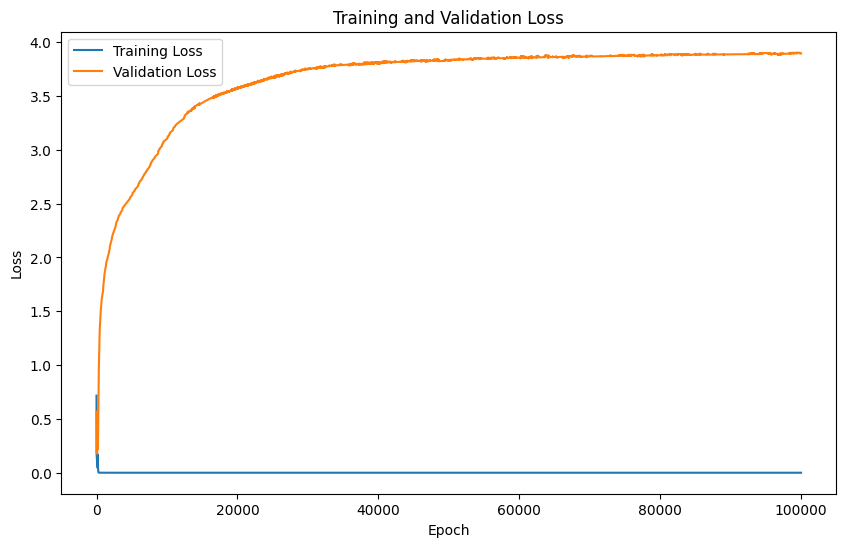

In [141]:

# Initialize model checkpoint
model_checkpoint = ModelCheckpoint()

# Training loop with validation
train_losses = []
val_losses = []

for epoch in tqdm(range(100000)):
    # Training phase
    net.train()
    optimizer.zero_grad()
    train_outputs = net(train_inputs)
    train_loss = criterion(train_outputs, train_labels)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Validation phase
    net.eval()
    with torch.no_grad():
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_losses.append(val_loss.item())
        
        # Save model if it's the best so far
        if model_checkpoint(val_loss.item(), net):
            print(f'Epoch {epoch}: New best model saved (val_loss: {val_loss.item():.4f})')
    
    # Print progress every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}:')
        print(f'Training Loss: {train_loss.item():.4f}')
        print(f'Validation Loss: {val_loss.item():.4f}')

# Save the final model
torch.save(net.state_dict(), 'final_model.pth')
print('Final model saved')

# Evaluate both models
print("\nEvaluating best model:")
net.load_state_dict(torch.load('best_model.pth'))
net.eval()
with torch.no_grad():
    test_outputs = net(test_inputs)
    best_test_loss = criterion(test_outputs, test_labels)
    best_predictions = (test_outputs > 0.5).float()
    best_accuracy = (best_predictions == test_labels).float().mean()
    print(f'Best Model Test Loss: {best_test_loss.item():.4f}')
    print(f'Best Model Test Accuracy: {best_accuracy.item():.4f}')

print("\nEvaluating final model:")
net.load_state_dict(torch.load('final_model.pth'))
net.eval()
with torch.no_grad():
    test_outputs = net(test_inputs)
    final_test_loss = criterion(test_outputs, test_labels)
    final_predictions = (test_outputs > 0.5).float()
    final_accuracy = (final_predictions == test_labels).float().mean()
    print(f'Final Model Test Loss: {final_test_loss.item():.4f}')
    print(f'Final Model Test Accuracy: {final_accuracy.item():.4f}')

# Save training history
np.save('train_losses.npy', train_losses)
np.save('val_losses.npy', val_losses)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

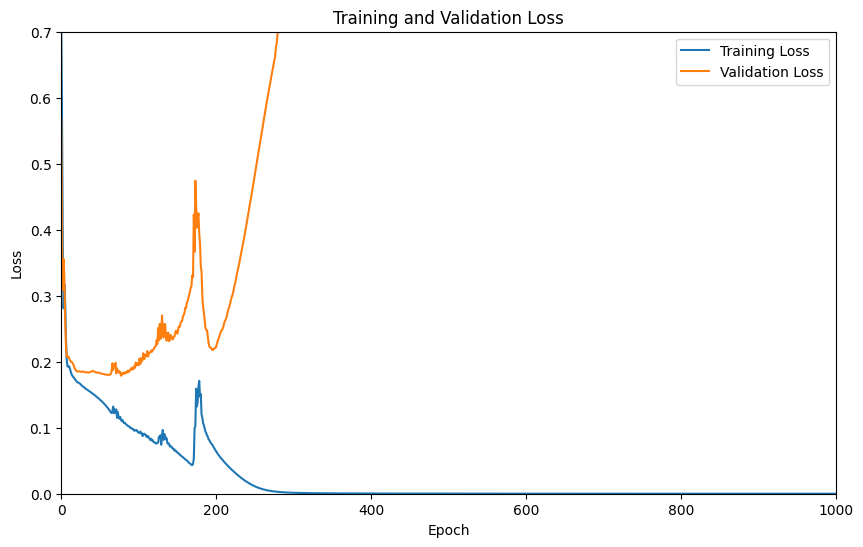

In [145]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlim(0, 1000)
plt.ylim(0, .7)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [246]:
from torchmetrics.classification import AveragePrecision, BinaryRecall, BinaryPrecision, BinaryF1Score, BinaryROC, BinaryPrecisionRecallCurve


In [2]:
average_precision = AveragePrecision(task="binary")

print("\nEvaluating best model:")
net.load_state_dict(torch.load('best_model.pth'))
net.eval()
with torch.no_grad():
    test_outputs = net(test_inputs)
    best_test_loss = criterion(test_outputs, test_labels)
    best_predictions = (test_outputs > 0.5).float()

    # precision recall curve


    best_accuracy = (best_predictions == test_labels).float().mean()
    print(f'Best Model Test Loss: {best_test_loss.item():.4f}')
    print(f'Best Model Test Accuracy: {best_accuracy.item():.4f}')

    average_precision(test_outputs,test_labels.int())


Evaluating best model:


NameError: name 'net' is not defined

In [45]:
ones = np.where(test_labels.cpu().numpy() == 1)[0]
zeros = np.where(test_labels.cpu().numpy() == 0)[0]


In [21]:
net.fc4

Linear(in_features=944, out_features=472, bias=True)

In [20]:
net.fc4.weight.data.shape

torch.Size([472, 944])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
o = test_inputs[[ones[0]],...].cpu().numpy()
o.shape

(1, 236)

In [58]:
w1 = net.fc1.weight.data.cpu().numpy() 
b1 = net.fc1.bias.data.cpu().numpy()

w2 = net.fc2.weight.data.cpu().numpy() 
b2 = net.fc2.bias.data.cpu().numpy()

w3 = net.fc3.weight.data.cpu().numpy() 
b3 = net.fc3.bias.data.cpu().numpy()

w4 = net.fc4.weight.data.cpu().numpy() 
b4 = net.fc4.bias.data.cpu().numpy()

w5 = net.fc5.weight.data.cpu().numpy() 
b5 = net.fc5.bias.data.cpu().numpy()

w6 = net.fc6.weight.data.cpu().numpy() 
b6 = net.fc6.bias.data.cpu().numpy()

In [62]:
x1 = o @ w1.T + b1
x2 = x1 @ w2.T + b2
x3 = x2 @ w3.T + b3
x4 = x3 @ w4.T + b4
x4_relu = torch.relu(torch.from_numpy(x4))
x4_relu = x4_relu.cpu().numpy()
x5 = x4_relu @ w5.T + b5
x6 = x5 @ w6.T + b6
x6_sigmoid = torch.sigmoid(torch.from_numpy(x6))
x6_sigmoid = x6_sigmoid.cpu().numpy()
x6_sigmoid.shape


(1, 1)

In [104]:
idxs = np.where(soz == 1)[0]

In [107]:
test_inputs.shape[1]

236

In [180]:
idxs = torch.where(test_labels == 1)[0]
test = test_inputs[idxs,:]
test.shape

net.load_state_dict(torch.load('final_model.pth'))
net.eval()
with torch.no_grad():
    t = net(test)

In [193]:
ec = torch.where(test == 0)[1][::2].cpu().numpy()

In [194]:
t_bool = t > 0.5
t_bool = t_bool.cpu().numpy()

<Axes: xlabel='id', ylabel='Proportion'>

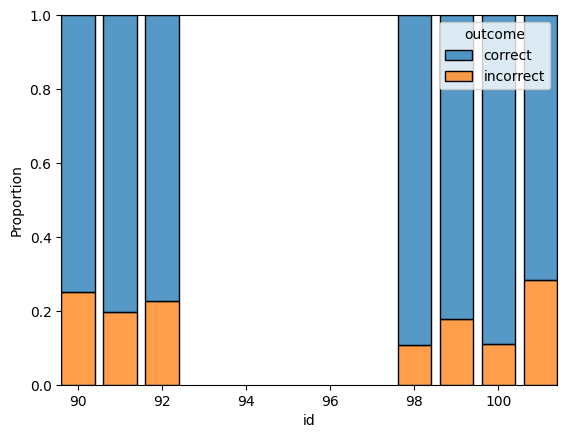

In [204]:
rows = []
for i in range(t_bool.shape[0]):
    tmp = {'id':ec[i], 'outcome':None, 'cnt':1}
    if t_bool[i]:
        tmp['outcome'] = 'correct'
    else:
        tmp['outcome'] = 'incorrect'
    rows.append(tmp)

df = pd.DataFrame(rows)
sns.histplot(
    data=df,
    x="id", hue="outcome",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)



In [271]:
idxs = torch.where(test_labels == 1)[0]

net.load_state_dict(torch.load('final_model.pth'))
net.eval()
with torch.no_grad():
    t = net(val_inputs)

t_bool = t > 0.5
t_bool = t_bool.cpu().numpy()
lookup = np.where(val_inputs.cpu().numpy() == 0)[1][::2]


rows = []
lbls = val_labels
for i in range(t_bool.shape[0]):
    tmp = {'id':lookup[i], 'outcome':None, 'cnt':1}
    if t_bool[i] and lbls[i] == 1:
        tmp['outcome'] = 'correct'
    elif t_bool[i] and lbls[i] == 0:
        tmp['outcome'] = 'incorrect'
    elif not t_bool[i] and lbls[i] == 1:
        tmp['outcome'] = 'incorrect'
    elif not t_bool[i] and lbls[i] == 0:
        tmp['outcome'] = 'correct'
    rows.append(tmp)
df = pd.DataFrame(rows)


# print(f"average_precision: {average_precision(t,lbls.int())}")


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'BinaryPrecisionRecallCurve'}, xlabel='Recall', ylabel='Precision'>)

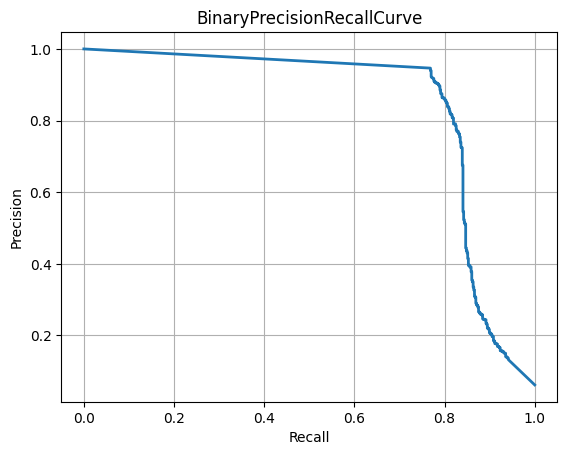

In [273]:
pr_curve = BinaryPrecisionRecallCurve()
pr_curve.update(t,lbls.int())
pr_curve.plot()

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'BinaryROC'}, xlabel='False positive rate', ylabel='True positive rate'>)

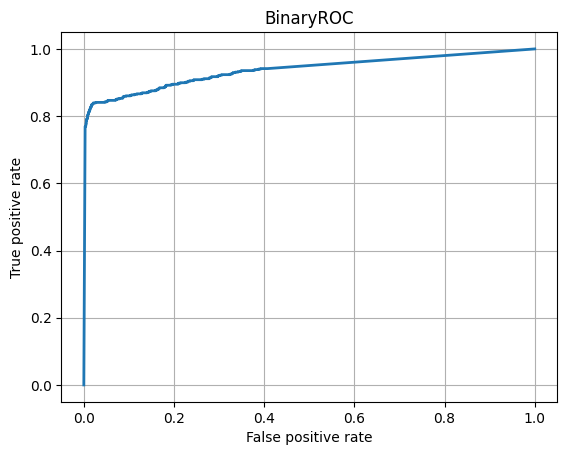

In [274]:
roc_curve = BinaryROC()
roc_curve.update(t,lbls.int())
roc_curve.plot()

In [275]:
np.mean(lbls.cpu().numpy(), axis=0)


array([0.06178681], dtype=float32)

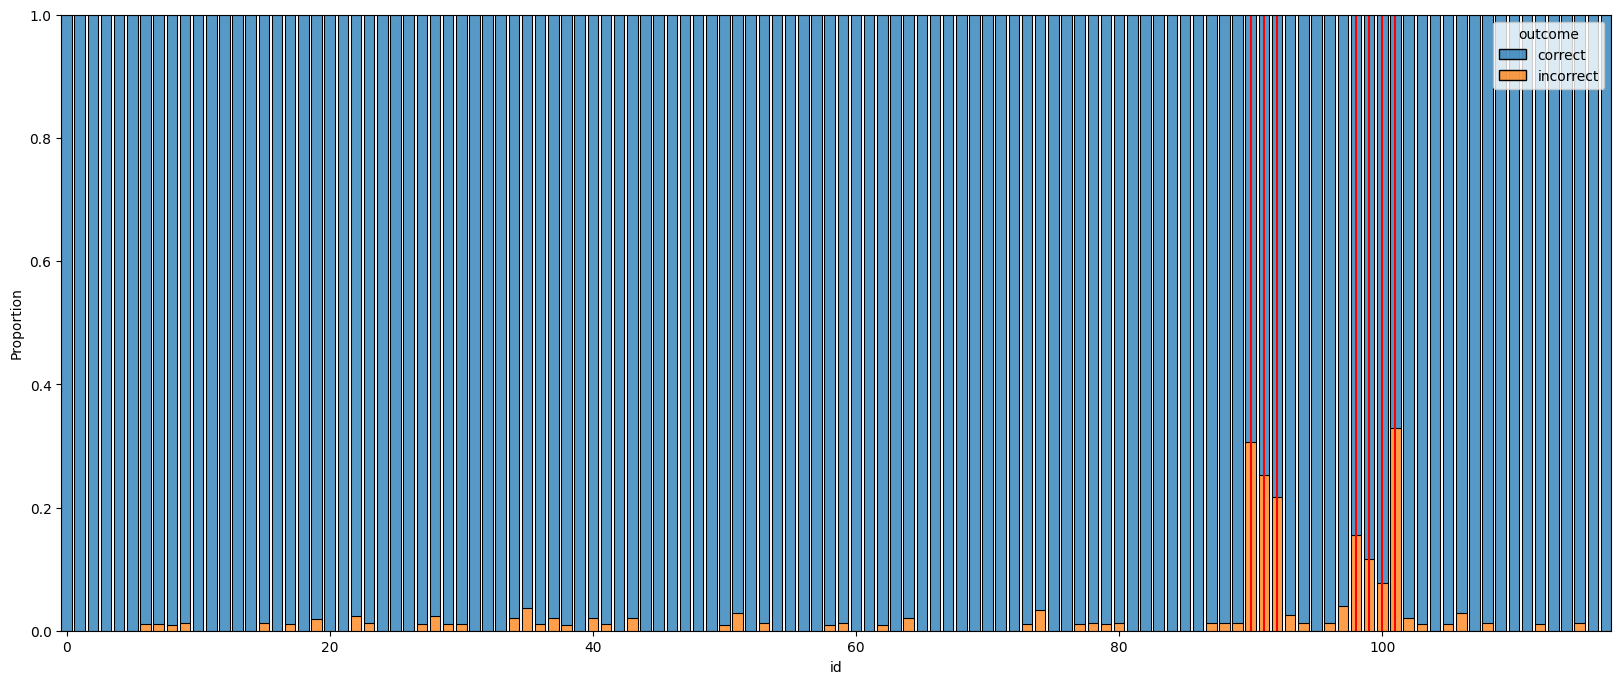

In [276]:
plt.figure(figsize=(20, 8))
sns.histplot(
    data=df,
    x="id", hue="outcome",
    multiple="fill", stat="proportion",
    discrete=True, shrink=.8
)

for i,z in enumerate(soz):
    if z == 1:
        plt.axvline(x=i, color='red')

In [71]:
x4_relu.shape

(1, 472)

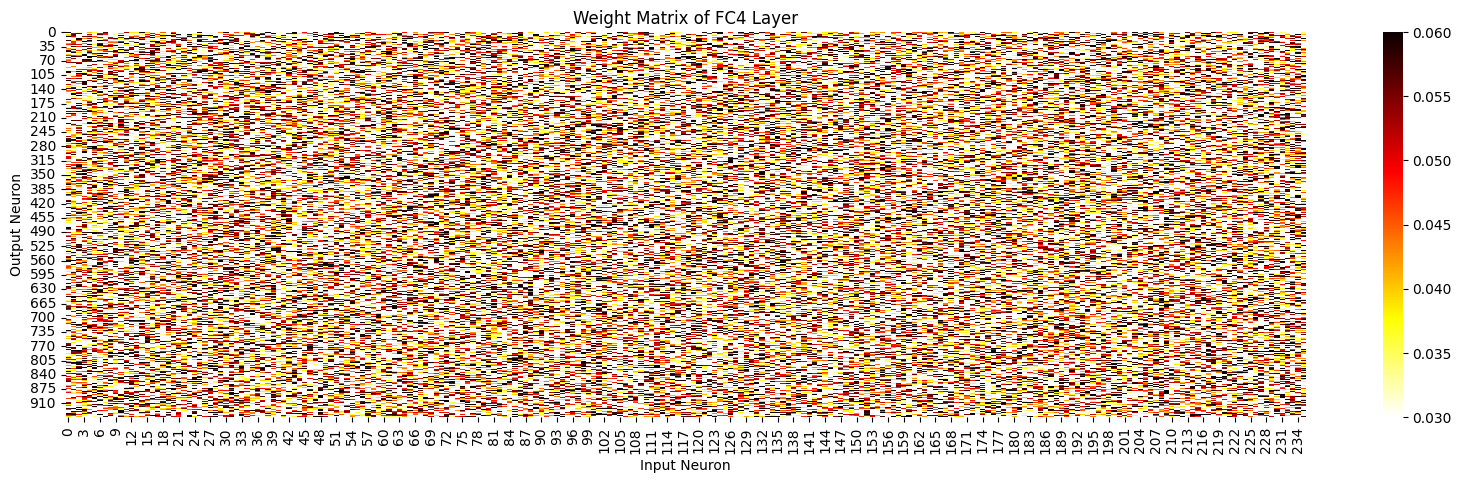

In [89]:
plt.figure(figsize=(20, 5))
q = w1
sns.heatmap(np.abs(q), cmap='hot_r', cbar=True ,vmin=0.03, vmax=.06)
plt.xlabel('Input Neuron')
plt.ylabel('Output Neuron')
plt.title('Weight Matrix of FC4 Layer')
plt.show()

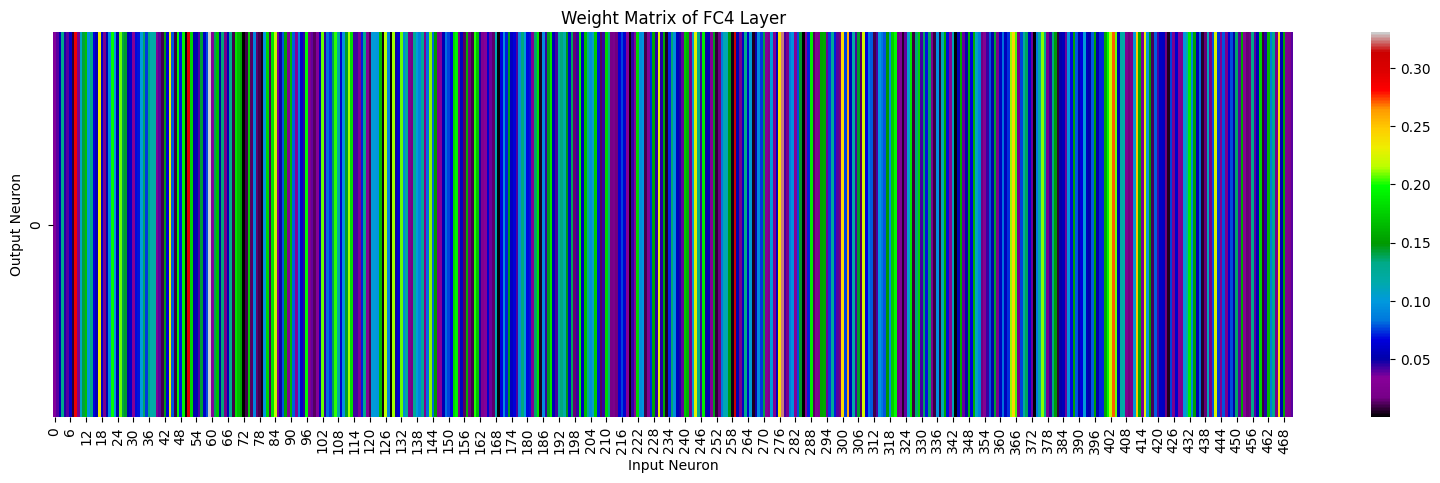

In [76]:
plt.figure(figsize=(20, 5))
sns.heatmap(np.abs(x4), cmap='nipy_spectral', cbar=True)
plt.xlabel('Input Neuron')
plt.ylabel('Output Neuron')
plt.title('Weight Matrix of FC4 Layer')
plt.show()


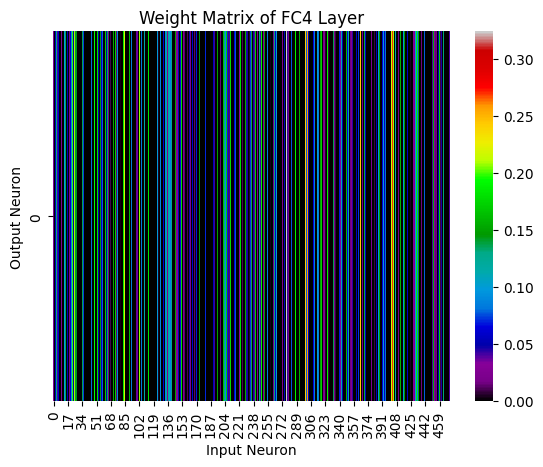

In [72]:

sns.heatmap(x4_relu, cmap='nipy_spectral', cbar=True)
plt.xlabel('Input Neuron')
plt.ylabel('Output Neuron')
plt.title('Weight Matrix of FC4 Layer')
plt.show()


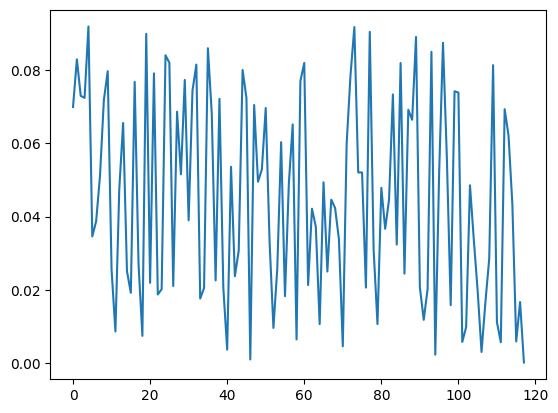

In [37]:
plt.plot(f)